# Supporting code and data for "Impact of switching bug trackers: a case study of a medium-sized open source project"

## Data collection

Given that creation dates of migrated bugs and comments were preserved during the GitHub import, we can extract and analyze data from before / after the switch by querying the GitHub API only. We will specifically use the GitHub GraphQL API because it allows fetching only the information we need, and at a much faster rate (we can get up to 100 nodes in a single request). Getting all the objects of a certain type requires then to repeat the request to go through all the pages of results.

Set `update_data_from_GitHub` to `True` and provide a personal `api_token` if you want to get fresh data from GitHub. Otherwise, this notebook will skip the data collection step and load the CSV files from the local filesystem.

In [0]:
#@title GitHub API settings { run: "auto", display-mode: "form" }
update_data_from_GitHub = False #@param {type:"boolean"}
api_token = '' #@param {type:"string"}

In [0]:
import csv
import requests

def requestAllPages(query,rows_and_next_variables,filename,columns):
  if not update_data_from_GitHub:
    return
  headers = {'Authorization': f'token {api_token}'}
  url = 'https://api.github.com/graphql'
  rows, variables = rows_and_next_variables(None)
  while len(variables)>0:
    json = {'query':query,'variables':variables.pop()}
    r = requests.post(url=url, json=json, headers=headers)
    if r.status_code == 403:
      print('Unauthorized request:')
      print(json)
    r.raise_for_status() # Abort if unsuccessful request
    new_rows, next_variables = rows_and_next_variables(r.json()['data'])
    rows += new_rows
    variables += next_variables
  if len(rows) > 0:
    with open(filename, 'w') as f:
      writer = csv.writer(f)
      writer.writerow(columns)
      writer.writerows(rows)

We identify migrated issues because their creation date is before October 18th, 2017. For all the migrated issues, we need to request the body of the issue to be able to extract information on the reporter. As soon as we are requesting only issues beyond the migration date, we stop requesting the body.

We keep the issue number (or the pull request) to be able to match comments and issues (or comments and pull requests).

In [0]:
import re
import pandas as pd

# This is the switch date for Coq
switch_date = pd.datetime(2017,10,18)
# For Ledger, the switch happened later (in January 2018) but the Bugzilla
# instance had been down since July 2017, so using the same switch_date
# for both projects is fine.

def fetch_issues(project_name,prefix=''):

  query = """
    query issueQuery($owner: String!, $repo: String!, $bodyText: Boolean!, $cursor: String) {
      repository(owner: $owner, name: $repo) {
        issues(first: 100, after: $cursor, orderBy:{field: CREATED_AT, direction:ASC}) {
          pageInfo {
            endCursor
            hasNextPage
          }
          nodes {
            createdAt
            author { login }
            bodyText @include (if: $bodyText)
            number
          }
        }
      }
    }
  """

  def rows_and_next_variables(data):
    if data is None:
      return [], [{'owner':project_name,'repo':project_name,'bodyText':True}]
    else:
      rows = []
      issues = data['repository']['issues']
      for node in issues['nodes']:
        date = pd.to_datetime(node['createdAt'])
        after_switch = date >= switch_date
        if after_switch:
          if node['author'] is None:
            # GitHub lost this information when the user deleted their account
            # but we had it from our previous fetching
            if (node['number'] == 8218 or node['number'] == 8450) and project_name == 'coq':
              author = "ruibaptista@live.com"
            else:
              author = None
              print(f"Warning: issue #{node['number']} has no author!")
          else:
            author = node['author']['login']
        else:
          if project_name == 'coq':
            m = re.search('From: @?(.*)', node['bodyText'])
            author = m.group(1)
          elif project_name == 'ledger':
            m = re.search('From: .* \(@(.*)\)', node['bodyText'])
            if m is None:
              author = None
            else:
              author = m.group(1)
        rows.append([date,author,node['number']])
      if issues['pageInfo']['hasNextPage']:
        return rows, [{'owner':project_name,
                       'repo':project_name,
                       'bodyText':not after_switch,
                       'cursor':issues['pageInfo']['endCursor']
                      }]
      else:
        return rows, []

  requestAllPages(
      query,
      rows_and_next_variables,
      f'{prefix}issues.csv',
      ['date','author','number']
  )

fetch_issues('coq')

In [0]:
def fetch_prs(project_name,prefix=''):

  query = """
    query pullRequestQuery($owner: String!, $repo: String!, $cursor: String) {
      repository(owner: $owner, name: $repo) {
        pullRequests(first: 100, after: $cursor) {
          pageInfo {
            endCursor
            hasNextPage
          }
          nodes {
            createdAt
            author { login }
            number
          }
        }
      }
    }
  """

  def rows_and_next_variables(data):
    if data is None:
      return [], [{'owner':project_name,'repo':project_name}]
    else:
      rows = []
      pullRequests = data['repository']['pullRequests']
      for node in pullRequests['nodes']:
        rows.append([node['createdAt'],node['author']['login'],node['number']])
      if pullRequests['pageInfo']['hasNextPage']:
        return rows, [{'owner':project_name,
                       'repo':project_name,
                       'cursor':pullRequests['pageInfo']['endCursor']
                      }]
      else:
        return rows, []

  requestAllPages(
      query,
      rows_and_next_variables,
      f'{prefix}pullrequests.csv',
      ['createdAt','author','number']
  )

fetch_prs('coq')

In [0]:
def fetch_issue_comments(project_name,prefix=''):

  query = """
    query commentQuery($owner: String!, $repo: String!, $number: Int!, $single: Boolean!, $issueCursor: String, $commentCursor: String) {
      repository(owner: $owner, name: $repo) {
        issues(first: 100, after: $issueCursor, orderBy:{field: CREATED_AT, direction:ASC}) @skip (if: $single) {
          pageInfo {
            endCursor
            hasNextPage
          }
          nodes {
            ... issue
          }
        }
        issue(number: $number) @include (if: $single) {
          ... issue
        }
      }
    }

    fragment issue on Issue {
      number
      comments(first: 100, after: $commentCursor) {
        pageInfo {
          endCursor
          hasNextPage
        }
        nodes {
          createdAt
          author { login }
          bodyText
        }
      }
    }
  """

  def treat_issue(issue):
    number = issue['number']
    rows, variables = [], []
    for comment in issue['comments']['nodes']:
      date = pd.to_datetime(comment['createdAt'])
      after_switch = date >= switch_date
      if after_switch:
        if comment['author'] is None:
          if number == 8450 and date < pd.datetime(2018,10,1) and project_name == 'coq':            
            # GitHub lost this information when the user deleted their account
            # but we know we had one comment from this user
            author = "ruibaptista@live.com"
          else:
            author = None
            print(f"Warning: issue #{number} has a comment with no author!")
        else:
          author = comment['author']['login']
      else:
        m = re.search('Comment author: @?(.*)', comment['bodyText'])
        if m is None:
          author = None
        else:
          author = m.group(1)      
      rows.append([date,author,number])
    if issue['comments']['pageInfo']['hasNextPage']:
      variables += [{
          'owner':project_name,
          'repo':project_name,
          'single':True,
          'number':number,
          'commentCursor':issue['comments']['pageInfo']['endCursor']
      }]
    return rows, variables

  def rows_and_next_variables(data):
    if data is None:
      return [], [{'owner':project_name,'repo':project_name,'single':False,'number':0}]
    else:
      if 'issues' in data['repository']:
        issues = data['repository']['issues']
        rows, variables = [], []
        for issue in issues['nodes']:
          new_rows, new_variables = treat_issue(issue)
          rows += new_rows
          variables += new_variables
        if issues['pageInfo']['hasNextPage']:
          variables += [{
              'owner':project_name,
              'repo':project_name,
              'single':False,
              'number':0,
              'issueCursor':issues['pageInfo']['endCursor']
          }]
        return rows, variables
      else:
        return treat_issue(data['repository']['issue'])

  requestAllPages(
      query,
      rows_and_next_variables,
      f'{prefix}comments.csv',
      ['date','author','number']
  )

fetch_issue_comments('coq')

In [0]:
def fetch_pr_comments(project_name,prefix=''):

  query = """
    query commentQuery($owner: String!, $repo: String!, $number: Int!, $single: Boolean!, $prCursor: String, $commentCursor: String) {
      repository(owner: $owner, name: $repo) {
        pullRequests(first: 100, after: $prCursor, orderBy:{field: CREATED_AT, direction:ASC}) @skip (if: $single) {
          pageInfo {
            endCursor
            hasNextPage
          }
          nodes {
            ... pullRequest
          }
        }
        pullRequest(number: $number) @include (if: $single) {
          ... pullRequest
        }
      }
    }

    fragment pullRequest on PullRequest {
      number
      comments(first: 100, after: $commentCursor) {
        pageInfo {
          endCursor
          hasNextPage
        }
        nodes {
          createdAt
          author { login }
        }
      }
    }
  """

  def treat_pr(pr):
    rows, variables = [], []
    number = pr['number']
    for comment in pr['comments']['nodes']:
      date = pd.to_datetime(comment['createdAt'])
      rows.append([date,comment['author']['login'],number])
    if pr['comments']['pageInfo']['hasNextPage']:
      variables += [{
          'owner':project_name,
          'repo':project_name,
          'single':True,
          'number':number,
          'commentCursor':pr['comments']['pageInfo']['endCursor']
      }]
    return rows, variables

  def rows_and_next_variables(data):
    if data is None:
      return [], [{'owner':project_name,'repo':project_name,'single':False,'number':0}]
    else:
      if 'pullRequests' in data['repository']:
        prs = data['repository']['pullRequests']
        rows, variables = [], []
        for pr in prs['nodes']:
          new_rows, new_variables = treat_pr(pr)
          rows += new_rows
          variables += new_variables
        if prs['pageInfo']['hasNextPage']:
          variables += [{
              'owner':project_name,
              'repo':project_name,
              'single':False,
              'number':0,
              'prCursor':prs['pageInfo']['endCursor']
          }]
        return rows, variables
      else:
        return treat_pr(data['repository']['pullRequest'])

  requestAllPages(
      query,
      rows_and_next_variables,
      f'{prefix}pr_comments.csv',
      ['date','author','number']
  )

fetch_pr_comments('coq')

## Data pre-processing

In [7]:
import os

def load_csv(filename):
  
  def aux(filename):
    return pd.read_csv(filename,parse_dates=True,index_col=0)
  
  df = aux(filename)
  print(f'File retrieved from local file system: {filename}')
  return df

issues = load_csv('issues.csv')
prs = load_csv('pullrequests.csv')
comments = load_csv('comments.csv')
pr_comments = load_csv('pr_comments.csv')

File retrieved from local file system: issues.csv
File retrieved from local file system: pullrequests.csv
File retrieved from local file system: comments.csv
File retrieved from local file system: pr_comments.csv


### Merging of duplicate Bugzilla accounts

The correspondence table between accounts used by the migration tool already allowed to merge several accounts together and  identify  individual  reporters.  When  we  discovered  later  on  that  some  reporter whose account had been not matched had created a GitHub account, we edited the imported bug reports and comments to use their GitHub nickname instead of their name and e-mail address as for unmatched Bugzilla reporters. There  are  also  some  duplicate  Bugzilla  accounts  that  have  no  corresponding GitHub  account.  For  our  (new) reporter  analysis,  we  still  need  to  merge  these.  We have identified such duplicate accounts manually so it is very likely that we have missed some but probably very few. Indeed, duplicates are usually very obvious because people have their name as part of their e-mail address (especially when they are using academic e-mail addresses).

In [8]:
to_merge = {
    'Alexandre.Miquel@pps.jussieu.fr':'Alexandre Miquel <miquel@ausone.inria.fr>',
    'Andreas Abel <andreas.abel@ifi.lmu.de>':'Andreas Abel <abela@chalmers.se>',
    'Benoit Montagu <benoit.montagu@m4x.org>':'Benoit Montagu <benoit.montagu@inria.fr>',
    'carlos@math1.unice.fr':'carlos@math.unice.fr',
    'Claude.Marche@inria.fr':'Claude.Marche@lri.fr',
    'marche@lri.fr':'Claude.Marche@lri.fr',
    'Clement.Renard@inria.fr':'Clement Renard <clrenard@pauillac.inria.fr>',
    'Damien.Pous@ens-lyon.fr':'Damien Pous <Damien.Pous@inria.fr>',
    'delahaye@cs.chalmers.se':'David.Delahaye@inria.fr',
    'Ed Morehouse <edmo@cs.cmu.edu>':'Ed Morehouse <emorehouse@wesleyan.edu>',
    'ethan.aubin@pobox.com':'ethan.aubin@gmail.com',
    'Francois Bobot <francois.bobot@cea.fr>':'François Bobot <bobot@lri.fr>',
    'François Pessaux <francois.pessaux@ensta-paristech.fr>':'François PESSAUX <francois_pessaux@yahoo.fr>',
    'hendriks@cs.kun.nl':'hendriks@cs.ru.nl',
    'mhendrik@cs.ru.nl':'hendriks@cs.ru.nl',
    'Jacek Chrząszcz <chrzaszcz@mimuw.edu.pl>':'Jacek Chrzaszcz <Jacek.Chrzaszcz@lri.fr>',
    'Jacek Chrząszcz <jacek.chrz@mailinator.com>':'Jacek Chrzaszcz <Jacek.Chrzaszcz@lri.fr>',
    'Jean-Marie Madiot <jm.madiot+lix+coq+bugs@gmail.com>':'Jean-Marie Madiot <madiot@gmail.com>',
    'Jonas B. Jensen <jbj@knef.dk>':'Jonas B. Jensen <jobr@itu.dk>',
    '=?ISO-8859-1?Q?Judica=EBl_Courant?= <Judicael.Courant@free.fr>':'Judicael.Courant@lri.fr',
    'Judicaël Courant <judicael.courant@imag.fr>':'Judicael.Courant@lri.fr',
    'loeb@cs.kun.nl':'loeb@cs.ru.nl',
    'Peter LeFanu Lumsdaine <p.l.lumsdaine@gmail.com>':'Peter LeFanu Lumsdaine <plumsdaine@ias.edu>',
    'Philippe Audebaud <Philippe.Audebaud@ens-lyon.fr>':'Philippe.Audebaud@sophia.inria.fr',
    'ruibaptista88@gmail.com': 'ruibaptista@live.com',
    'samuel.mimram@ens-lyon.org':'Samuel Mimram <samuel.mimram@ens-lyon.fr>',
    'Solange Coupet_Grimal <Solange.Coupet_Grimal@sophia.inria.fr>':'Solange Coupet-Grimal <Solange.Coupet@cmi.univ-mrs.fr>',
    'Steven Tschantz <stt314@comcast.net':'Steven Tschantz <steven.tschantz@vanderbilt.edu>',
    'virgile.prevosto@m4x.org':'virgile.prevosto@lip6.fr'
}

issues = issues.assign(
    author = [to_merge[author] if author in to_merge else author for author in issues['author']]
)

print('After merging duplicates account, we have %d distinct bug reporters.' % issues.nunique()['author'])

nb_of_reporters_before_the_switch = issues[issues.index < switch_date].nunique()['author']
print('%d of them were active before the switch' % nb_of_reporters_before_the_switch)

After merging duplicates account, we have 725 distinct bug reporters.
606 of them were active before the switch


We also computed the number of Bugzilla accounts before the migration by running `grep "<reporter[> ]" bugzilla.xml | cut -d'>' -f 2 | cut -d'<' -f 1 | sort | uniq | wc -l` (`bugzilla.xml` being the XML dump of the Bugzilla reports at the time of the migration). The result is 686. Thus, all in all:

In [9]:
bugzilla_account_duplicate_nb = 686 - nb_of_reporters_before_the_switch
print(f'We have identified {bugzilla_account_duplicate_nb} duplicate Bugzilla accounts.')
print('This represents %d%% of all Bugzilla accounts.' % (round(bugzilla_account_duplicate_nb / nb_of_reporters_before_the_switch * 100)))

We have identified 80 duplicate Bugzilla accounts.
This represents 13% of all Bugzilla accounts.


### Removal of migration artifact comments

If a comment was posted exactly at the same date and time as the corresponding issue, then it means that it is an artifact of the bug migration.

In [0]:
def remove_migration_artifact_comments(issues,comments):
  issues_by_number = issues.assign(date=issues.index).set_index('number')
  return comments[
      [date != issues_by_number.loc[row['number']]['date']
       for date, row in comments.iterrows()]
  ]

comments = remove_migration_artifact_comments(issues,comments)

### Only consider post-2008 data

Bugs and comments from July, 2007 and before were migrated a first time from a previous bug tracker (JitterBug). Comments do not have valid author information and closed bugs have not been migrated.

In [0]:
comments = comments[comments.index >= pd.datetime(2008,1,1)]
issues = issues[issues.index >= pd.datetime(2008,1,1)]

### Excluding specific reporters

- We have one particular reporter / contributor, Jason Gross, who is alone responsible for creating almost a quarter (24%) of all bug reports (and an even greater proportion when we only consider post-2008 bug reports). To avoid having the behavior of a single individual strongly impact the overall statistics, we exclude his comments, bug reports and pull requests and all the comments they received from our analysis.
- We also exclude from this analysis the developer who was the main advocate of the bug  tracker switch as it could have influenced his behavior before and after the switch.

In [12]:
def local():

  nb_of_reports_by_Jason_Gross = len(issues[issues['author'] == 'JasonGross'])
  total_nb_of_reports = len(issues)

  print(f'Number of post-2008 bug reports: {total_nb_of_reports}')
  print(f'Reports by Jason Gross: {nb_of_reports_by_Jason_Gross}')
  print('Overall proportion: %d%%' % (nb_of_reports_by_Jason_Gross / total_nb_of_reports * 100))

local()

Number of post-2008 bug reports: 5459
Reports by Jason Gross: 1484
Overall proportion: 27%


In [0]:
excluded_reporters = ['JasonGross','Zimmi48']

excluded_issues = issues[issues['author'].isin(excluded_reporters)]['number'].values

comments = comments[~comments['number'].isin(excluded_issues) & ~comments['author'].isin(excluded_reporters)]
issues = issues[~issues['author'].isin(excluded_reporters)]

excluded_prs = prs[prs['author'].isin(excluded_reporters)]['number'].values

pr_comments = pr_comments[~pr_comments['number'].isin(excluded_prs) & ~pr_comments['author'].isin(excluded_reporters)]
prs = prs[~prs['author'].isin(excluded_reporters)]

## Variables

### Developers


The following list was obtained by running `git shortlog -ns --after=2008-01-01 --before=2019-01-17 | awk '$1 > 100'` on 2018-09-14, which is the day we gathered the rest of the data. It corresponds to the people who have authored more than 100 commits since 2008.

```
  2946	Hugo Herbelin
  2783	Pierre-Marie Pédrot
  2115	Maxime Dénès
  1654	Matthieu Sozeau
  1480	Pierre Letouzey
  1017	Enrico Tassi
   830	Emilio Jesus Gallego Arias
   700	Gaëtan Gilbert
   650	Théo Zimmermann
   540	Arnaud Spiwack
   438	Pierre Boutillier
   427	Guillaume Melquiond
   321	Jason Gross
   290	Matej Košík
   238	Stéphane Glondu
   151	Jean-Marc Notin
   128	Bruno Barras
   120	Vincent Laporte
```

We will call "developers" the members of this list and "others" the rest of the bug reporters / pull request authors.

These developers are responsible for 16828 commits (info obtained with `git shortlog -ns --after=2008-01-01 --before=2019-01-17 | awk '{if ($1 > 100) sum+=$1} END{print sum;}'`) out of a total of 18388 commits (obtained with `git rev-list --count HEAD --after=2008-01-01 --before=2019-01-17`). This is 91.5% of all commits.

We also define a sub-list of these "developers" that were active during the two months preceding the migration by running `comm -12 <(git shortlog -s --after=2008-01-01 | awk '$1 > 100' | cut -f2) <(git shortlog -s --after=2017-08-18 --before=2017-10-17 | cut -f2 | sort)`, the result being:

```
Emilio Jesus Gallego Arias
Enrico Tassi
Gaëtan Gilbert
Guillaume Melquiond
Hugo Herbelin
Jason Gross
Matthieu Sozeau
Maxime Dénès
Pierre Letouzey
Pierre-Marie Pédrot
Théo Zimmermann
```

The other part of the list (`comm -23 <(git shortlog -s --after=2008-01-01 | awk '$1 > 100' | cut -f2) <(git shortlog -s --after=2017-08-18 --before=2017-10-17 | cut -f2 | sort)`) is thus:

```
Arnaud Spiwack
Bruno Barras
Jean-Marc Notin
Matej Košík
Pierre Boutillier
Stéphane Glondu
Vincent Laporte
```

In [0]:
active_devs = [
    'ejgallego', # Emilio Jesus Gallego Arias
    'gares', # Enrico Tassi
    'SkySkimmer', # Gaëtan Gilbert
    'silene', # Guillaume Melquiond
    'herbelin', # Hugo Herbelin
    'JasonGross', # Jason Gross
    'mattam82', # Matthieu Sozeau
    'maximedenes', # Maxime Dénès
    'letouzey', # Pierre Letouzey
    'ppedrot', # Pierre-Marie Pédrot
    'Zimmi48' # Théo Zimmermann
]

devs = active_devs + [
    'aspiwack', # Arnaud Spiwack
    'barras', # Bruno Barras
    'Jean-Marc Notin <notin@lix.polytechnique.fr>', # Jean-Marc Notin
    'matejkosik', # Matej Košík
    'pirbo', # Pierre Boutillier
    'glondu', # Stéphane Glondu
    'vbgl' # Vincent Laporte
]

### Releases

The dates of new releases correspond to the announcement dates on Coq-Club or the news items at https://coq.inria.fr/news/, whichever comes first.

In [0]:
# Major releases

major_releases = [
    pd.datetime(2009,2,15), # 8.2
    pd.datetime(2010,10,14), # 8.3
    pd.datetime(2012,8,12), # 8.4
    pd.datetime(2016,1,21), # 8.5
    pd.datetime(2016,12,14), # 8.6
    pd.datetime(2017,10,17), # 8.7
    pd.datetime(2018,4,17) # 8.8
]

# Beta releases

beta_releases = [
    pd.datetime(2008,6,15), # 8.2 beta
    pd.datetime(2010,2,10), # 8.3 beta
    pd.datetime(2011,12,27), # 8.4 beta
    pd.datetime(2015,1,21), # 8.5 beta 1
    pd.datetime(2015,4,22), # 8.5 beta 2
    pd.datetime(2015,11,11), # 8.5 beta 3
    pd.datetime(2016,11,19), # 8.6 beta
    pd.datetime(2017,9,6), # 8.7 beta 1
    pd.datetime(2017,10,6), # 8.7 beta 2
    pd.datetime(2018,3,18), # 8.8 beta
    pd.datetime(2018,11,6) # 8.9 beta
]

releases = sorted(major_releases + beta_releases)

In [0]:
def after_release(date):
  releases = major_releases
  last_release = None
  for i in range(len(releases)):
    if releases[i] > date:
      break
    last_release = i
  if last_release is None:
    return None
  elif (date-releases[last_release]).days <= 14:
    return last_release
  else:
    return None

def after_beta(date):
  releases = beta_releases
  last_release = None
  for i in range(len(releases)):
    if releases[i] > date:
      break
    last_release = i
  if last_release is None:
    return None
  elif (date-releases[last_release]).days <= 14:
    return last_release
  else:
    return None


### Time periods

We group our data points in bins of 1 day, 1 week, 2 weeks, and 4 weeks. Our time periods are "centered" around the bug tracker switch date (they have a "reldate" field which is zero for the first period after the switch, postive for subsequent periods and negative for periods before the switch). The periods are indexed by a date which is the last day in the period. We also define a number of outcome variables. We remove the first and the last period as they might not be complete.

In [0]:
import numpy as np

def df_1D_1W_2W_4W(df,filename_prefix=None,switch_date=switch_date):
  dev = df['author'].isin(devs)
  reldays = (df.index-switch_date).days
  
  df = df.assign(
      count=1,
      dev_count=dev,
      other_count=~dev,
      dev_author=[author if author in devs else np.NaN for author in df['author']],
      other_author=[author if not author in devs else np.NaN for author in df['author']],
      new=~df.duplicated(subset=['author']),
      reldate_1D=reldays,
      reldate_1W=np.floor(reldays/7),
      reldate_2W=np.floor(reldays/14),
      reldate_4W=np.floor(reldays/28),
      date_min=df.index,
      date_max=df.index,
      after_switch=reldays>=0
  )
  
  # Hack, we add elements to all days so that all bins exist after groupby
  # But these fake elements won't influence the aggregated values because they
  # are only made of 0 and NaN
  
  day_range = range(1,(df['date_min'][-1]-df['date_min'][0]).days)
  zero_list = [0 for day in day_range]
  nan_list = [np.NaN for day in day_range]
  date_list = [df['date_min'][0] + pd.to_timedelta(day,unit='D') for day in day_range]
  reldays = np.array([(date-switch_date).days for date in date_list])
  
  df_with_fake_elements = df.append(pd.DataFrame({
      'count':zero_list,
      'dev_count':zero_list,
      'other_count':zero_list,
      'author':nan_list,
      'dev_author':nan_list,
      'other_author':nan_list,
      'new':zero_list,
      'reldate_1D':reldays,
      'reldate_1W':np.floor(reldays/7),
      'reldate_2W':np.floor(reldays/14),
      'reldate_4W':np.floor(reldays/28),
      'date_min':date_list,
      'date_max':date_list,
      'after_switch':reldays>=0
  }))
  
  def group_by_reldate(key_suffix):
    agg = {
        'count':'sum',
        'dev_count':'sum',
        'other_count':'sum',
        'author':'nunique',
        'dev_author':'nunique',
        'other_author':'nunique',
        'new':'sum',
        'date_min':'min',
        'date_max':'max'
    }

    grouped = df_with_fake_elements.groupby(f'reldate{key_suffix}').agg(agg).iloc[1:-1]
    
    result = grouped.assign(
        reldate=grouped.index,
        after_switch=(grouped.index>=0),
        date=(grouped['date_min'] + (grouped['date_max'] - grouped['date_min']) / 2)
    ).set_index('date')
    
    result = result.drop(['date_min','date_max'],axis=1)
    
    result.index = result.index.round('D')
    
    # Create variables after_release and after_beta
    result = result.assign(
        after_release= [after_release(date) is not None for date in result.index],
        after_beta= [after_beta(date) is not None for date in result.index],
    )
    # Create one variable per release
    for i in range(len(releases)):
      result = result.assign(
          **{f'after_release_{i}':[after_release(date) == i for date in result.index]}
      )
    
    if filename_prefix is not None:
      result.to_csv(filename_prefix + key_suffix + '.csv')
    
    return result
  
  return df,group_by_reldate('_1D'),group_by_reldate('_1W'),group_by_reldate('_2W'),group_by_reldate('_4W')

In [18]:
issues,issues_1D,issues_1W,issues_2W,issues_4W = df_1D_1W_2W_4W(issues)

print(
    f'Average number of bug reports by week (since 2008): %d' %
    issues_1W.mean()['count']
)

print('Quantiles of bug reports by week (since 2008):')
print(issues_1W.quantile([.1, .25, .5, .75, .9])['count'])

print(
    f'\n\nAverage number of bug reports by 2-week period (since 2008): %d' %
    issues_2W.mean()['count']
)

print('Quantiles of bug reports by 2-week period (since 2008):')
print(issues_2W.quantile([.1, .25, .5, .75, .9])['count'])

print(
    f'\n\nAverage number of new reporters by 4-week period (since 2008): %d' %
    issues_4W.mean()['new']
)

print('Quantiles of new reporters by 4-week period (since 2008):')
print(issues_4W.quantile([.1, .25, .5, .75, .9])['new'])

Average number of bug reports by week (since 2008): 6
Quantiles of bug reports by week (since 2008):
0.10     1.0
0.25     3.0
0.50     5.0
0.75     9.0
0.90    14.6
Name: count, dtype: float64


Average number of bug reports by 2-week period (since 2008): 13
Quantiles of bug reports by 2-week period (since 2008):
0.10     4.0
0.25     6.0
0.50    11.0
0.75    17.0
0.90    28.0
Name: count, dtype: float64


Average number of new reporters by 4-week period (since 2008): 3
Quantiles of new reporters by 4-week period (since 2008):
0.10    1.0
0.25    2.0
0.50    3.0
0.75    5.0
0.90    8.0
Name: new, dtype: float64


In [19]:
comments,comments_1D,comments_1W,comments_2W,comments_4W = df_1D_1W_2W_4W(comments)

print(
    f'Average number of bug comments per week (since 2008): %d' %
    comments_1W.mean()['count']
)

print('Quantiles of bug comments per week (since 2008):')
print(comments_1W.quantile([.1, .25, .5, .75, .9])['count'])

print(
    f'\n\nAverage number of bug comments by 2-week period (since 2008): %d' %
    comments_2W.mean()['count']
)

print('Quantiles of bug comments by 2-week period (since 2008):')
print(comments_2W.quantile([.1, .25, .5, .75, .9])['count'])

print(
    f'\n\nAverage number of new commentators by 4-week period (since 2008): %d' %
    comments_4W.mean()['new']
)

print('Quantiles of new commentators by 4-week period (since 2008):')
print(comments_4W.quantile([.1, .25, .5, .75, .9])['new'])

Average number of bug comments per week (since 2008): 21
Quantiles of bug comments per week (since 2008):
0.10     1.0
0.25     5.0
0.50    12.0
0.75    26.0
0.90    59.7
Name: count, dtype: float64


Average number of bug comments by 2-week period (since 2008): 43
Quantiles of bug comments by 2-week period (since 2008):
0.10      5.0
0.25     10.5
0.50     25.0
0.75     51.5
0.90    120.6
Name: count, dtype: float64


Average number of new commentators by 4-week period (since 2008): 2
Quantiles of new commentators by 4-week period (since 2008):
0.10    1.0
0.25    1.0
0.50    2.0
0.75    4.0
0.90    5.0
Name: new, dtype: float64


In [0]:
prs,prs_1D,prs_1W,prs_2W,prs_4W = df_1D_1W_2W_4W(prs)
pr_comments,pr_comments_1D,pr_comments_1W,pr_comments_2W,pr_comments_4W = df_1D_1W_2W_4W(pr_comments)

## Descriptive statistics

In [0]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    'figure.figsize': [3.5, 3.5],
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7,
    'axes.titlesize': 8,
    'legend.frameon': True,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,
    'lines.linewidth': 1,
    'figure.dpi': 150.0
})

In [0]:
def less_ticks(ax,every_nth):
  # Reduce the number of ticks following https://stackoverflow.com/a/49714879/3335288
  for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
      label.set_visible(False)

### Cumulative number of bug reports since 2008 on the Coq bug tracker

In [0]:
data_collection_date = pd.datetime(2019,1,8)

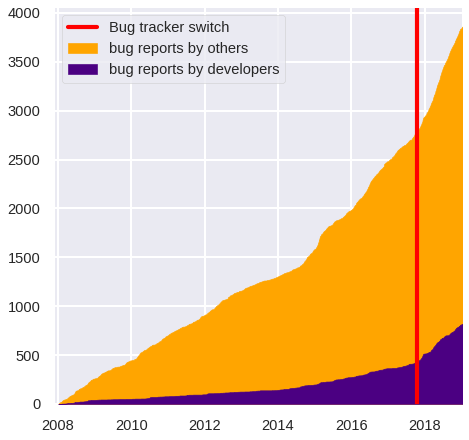

In [24]:
def local():

  #ax1 = plt.subplot(1,2,1)
  plt.fill_between(issues.index,issues.agg({'count':'cumsum'})['count'],label='bug reports by others',color='orange')
  plt.fill_between(issues.index,issues.agg({'dev_count':'cumsum'})['dev_count'],label='bug reports by developers',color='indigo')
  plt.axvline(x=switch_date,color='red',lw=2,label='Bug tracker switch')
  plt.legend()
  plt.ylim(bottom=0)

  #plt.subplot(1,2,2,sharex=ax1)

  plt.xlim(left=pd.datetime(2007,12,1),right=data_collection_date)

  plt.savefig('cumulative_bugs.eps')

local()

### Cumulative number of bug comments since 2008 on the Coq bug tracker

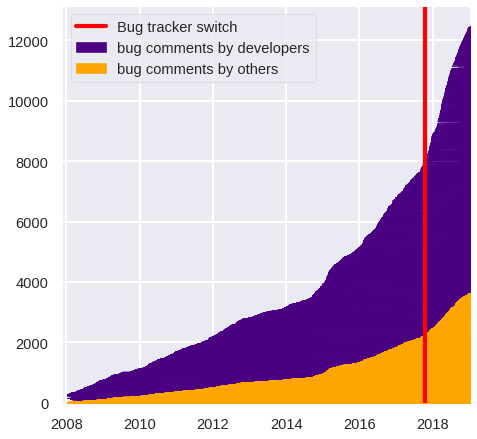

In [25]:
def local():

  plt.fill_between(comments.index,comments.agg({'count':'cumsum'})['count'],label='bug comments by developers',color='indigo')
  plt.fill_between(comments.index,comments.agg({'other_count':'cumsum'})['other_count'],label='bug comments by others',color='orange')
  plt.axvline(x=switch_date,color='red',lw=2,label='Bug tracker switch')
  plt.legend()
  plt.ylim(bottom=0)

  plt.xlim(left=pd.datetime(2007,12,1),right=data_collection_date)

  plt.savefig('cumulative_comments.eps')

local()

### Cumulative number of pull requests on the Coq GitHub repository

In [0]:
implementors_workshops = [
    pd.datetime(2015,6,22),
    pd.datetime(2016,5,30),
    pd.datetime(2017,6,12),
    pd.datetime(2018,5,28)
]

def prs_vertical_lines():
  for date in implementors_workshops:
    line = plt.axvline(x=date,color='black', linestyle="-",lw=0.5)
  line.set_label('Coq Implementors Workshops')
  plt.axvline(x=pd.datetime(2017,2,3),color='black', linestyle="--",lw=1.2,label='Introduction of systematic CI testing')

In [27]:
def local():

  _, ax = plt.subplots()
  
  plt.fill_between(prs.index,prs.agg({'count':'cumsum'})['count'],label='pull requests by developers',color='indigo')
  plt.fill_between(prs.index,prs.agg({'other_count':'cumsum'})['other_count'],label='pull requests by others',color='orange')
  prs_vertical_lines()
  plt.xlim(left=pd.datetime(2014,7,1),right=data_collection_date)
  plt.ylim(bottom=0)
  plt.legend()
  
  less_ticks(ax,2)

local()

### Evolution of pull request creation for developers / external contributors

In [28]:
def local():

  ax1 = plt.subplot(2,1,1)
  plt.plot(prs_4W['dev_count'],label='')
  prs_vertical_lines()
  plt.legend()
  plt.title('Number of pull requests by developers by 4-week period')

  plt.setp(ax1.get_xticklabels(), visible=False)

  plt.subplot(2,1,2,sharex=ax1)
  plt.plot(prs_4W['other_count'],label='')
  prs_vertical_lines()
  plt.title('Number of pull requests by others by 4-week period')

  plt.xlim(left=pd.datetime(2014,1,1),right=pd.datetime(2019,1,8))

local()

### Variation of bug reporting by month and by hour

#### Average number of bug reports per month (over years 2008-2017)

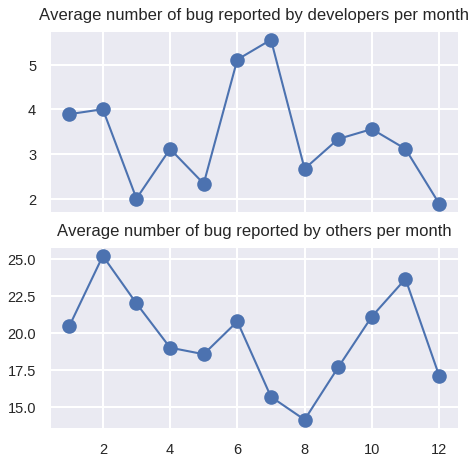

In [29]:
def local():

  issue_by_month_abs = issues[issues.index < pd.datetime(2017,1,1)].resample('M').sum()

  average_issue_nb_by_month = issue_by_month_abs.assign(
      month=issue_by_month_abs.index.month
  ).groupby('month').mean()

  ax1 = plt.subplot(2, 1, 1)
  plt.plot(average_issue_nb_by_month['dev_count'],'-o')
  plt.title('Average number of bug reported by developers per month')

  plt.setp(ax1.get_xticklabels(), visible=False)

  plt.subplot(2, 1, 2)
  plt.plot(average_issue_nb_by_month['other_count'],'-o')
  plt.title('Average number of bug reported by others per month')

local()

#### Distribution of bug creation by hour of the day before (since 2016) / after the switch.

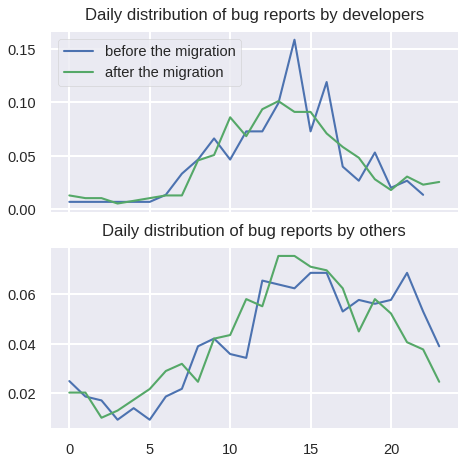

In [30]:
def local():

  def bug_by_hour(cond):
    return issues.assign(hour=issues.index.hour)[cond].groupby('hour').sum()['count'] / len(issues[cond])

  cond_before = (issues['after_switch'] == False) & (issues.index >= pd.datetime(2016,1,1))
  cond_after = issues['after_switch'] == True
  dev_issues = issues['author'].isin(devs)

  ax1 = plt.subplot(2, 1, 1)
  plt.plot(bug_by_hour(cond_before & dev_issues),label='before the migration')
  plt.plot(bug_by_hour(cond_after & dev_issues),label='after the migration')
  plt.title('Daily distribution of bug reports by developers')
  plt.legend()
  plt.setp(ax1.get_xticklabels(), visible=False)

  plt.subplot(2, 1, 2)
  plt.plot(bug_by_hour(cond_before & ~dev_issues),label='before the migration')
  plt.plot(bug_by_hour(cond_after & ~dev_issues),label='after the migration')
  plt.title('Daily distribution of bug reports by others')

local()

### Graphs with new release dates

In [0]:
def release_vertical_lines():
  for release in major_releases:
    line=plt.axvline(x=release,color='black',linestyle="-",lw=0.4)
  line.set_label('major releases')
  for release in beta_releases:
    line=plt.axvline(x=release,color='black',linestyle="--",lw=0.4)
  line.set_label('beta releases')
  plt.axvline(x=switch_date,color='red',linestyle='-',lw=1.2,label='bug tracker switch')

#### Number of bugs

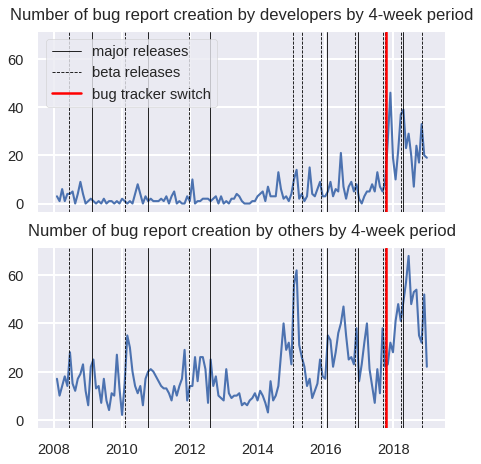

In [32]:
def local():

  ax1 = plt.subplot(2,1,1)
  plt.plot(issues_4W['dev_count'],label='')
  release_vertical_lines()
  plt.setp(ax1.get_xticklabels(), visible=False)
  plt.title('Number of bug report creation by developers by 4-week period')

  plt.legend(loc='upper left')

  plt.subplot(2,1,2,sharex=ax1,sharey=ax1)
  plt.plot(issues_4W['other_count'],label='')
  release_vertical_lines()
  plt.title('Number of bug report creation by others by 4-week period')

  plt.savefig('bug_nb_with_releases.eps')

local()

#### Number of comments

In [33]:
def local():

  ax1 = plt.subplot(2,1,1)
  plt.plot(comments_4W['dev_count'],label='')
  release_vertical_lines()
  plt.setp(ax1.get_xticklabels(), visible=False)
  plt.title('Number of bug comments by developers by 4-week period')

  plt.legend(loc='upper left')

  plt.subplot(2,1,2,sharex=ax1,sharey=ax1)
  plt.plot(comments_4W['other_count'],label='')
  release_vertical_lines()
  plt.title('Number of bug comments by others by 4-week period')

  plt.savefig('comments_with_releases.eps')

local()

#### Number of reporters

In [34]:
def local():

  ax1 = plt.subplot(2,1,1)
  plt.plot(issues_4W['dev_author'],label='')
  release_vertical_lines()
  plt.setp(ax1.get_xticklabels(), visible=False)
  plt.title('Number of developer reporters by 4-week period')

  plt.legend(loc='upper left')

  plt.subplot(2,1,2,sharex=ax1,sharey=ax1)
  plt.plot(issues_4W['other_author'],label='')
  release_vertical_lines()
  plt.title('Number of other reporters by 4-week period')

local()

#### Number of commentators

In [35]:
def local():

  ax1 = plt.subplot(2,1,1)
  plt.plot(comments_4W['dev_author'],label='')
  release_vertical_lines()
  plt.setp(ax1.get_xticklabels(), visible=False)
  plt.title('Number of developer commentators by 4-week period')

  plt.legend(loc='upper left')

  plt.subplot(2,1,2,sharex=ax1,sharey=ax1)
  plt.plot(comments_4W['other_author'],label='')
  release_vertical_lines()
  plt.title('Number of other commentators by 4-week period')

local()

#### Number of new reporters by 4-week period

In [36]:
def local():

  plt.plot(issues_4W['new'],label='')
  release_vertical_lines()
  plt.legend(loc='upper left')

local()

#### Number of new commentators by 4-week period 

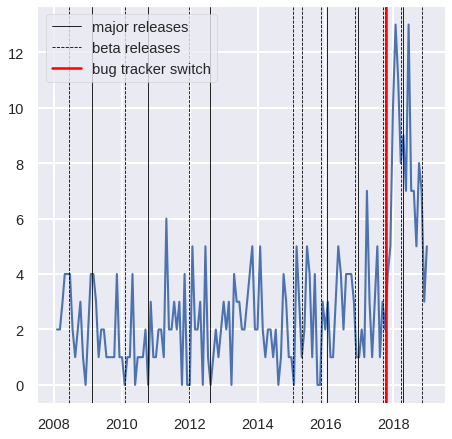

In [37]:
def local():

  plt.plot(comments_4W['new'],label='')
  release_vertical_lines()
  plt.legend(loc='upper left')

local()

#### Number of distinct developers creating bug reports vs number of distinct developers creating pull requests

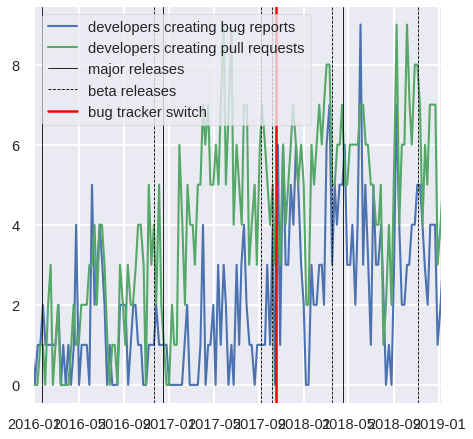

In [38]:
def local():

  plt.plot(issues_1W['dev_author'],label='developers creating bug reports')
  plt.plot(prs_1W['dev_author'],label='developers creating pull requests')
  #prs_vertical_lines()
  release_vertical_lines()
  plt.xlim(left=pd.datetime(2016,1,1),right=data_collection_date)
  plt.legend()

local()

#### Commenting rate over time: bug / pull request comparison

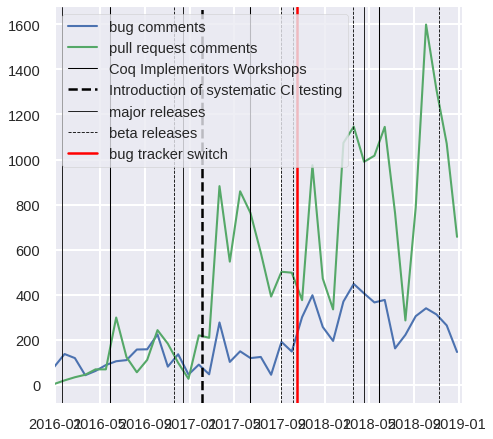

In [39]:
def local():

  plt.plot(comments_4W['count'],label='bug comments')
  plt.plot(pr_comments_4W['count'],label='pull request comments')
  prs_vertical_lines()
  release_vertical_lines()
  plt.xlim(left=pd.datetime(2016,1,1),right=data_collection_date)
  plt.legend()

local()

#### Number of distinct developer commentators : bug / pull request comparison

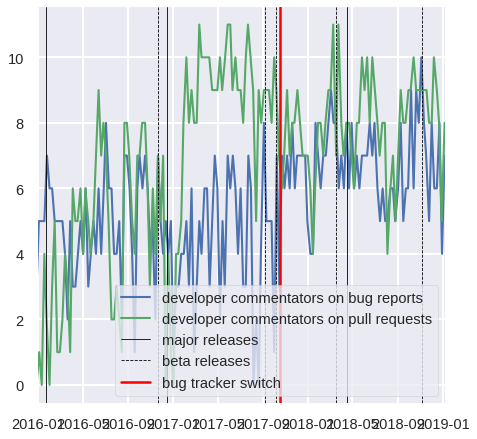

In [40]:
def local():

  plt.plot(comments_1W['dev_author'],label='developer commentators on bug reports')
  plt.plot(pr_comments_1W['dev_author'],label='developer commentators on pull requests')
  #prs_vertical_lines()
  release_vertical_lines()
  plt.xlim(left=pd.datetime(2016,1,1),right=data_collection_date)
  plt.legend()

local()

### Number of bugs reported by individual developers per 4-week period

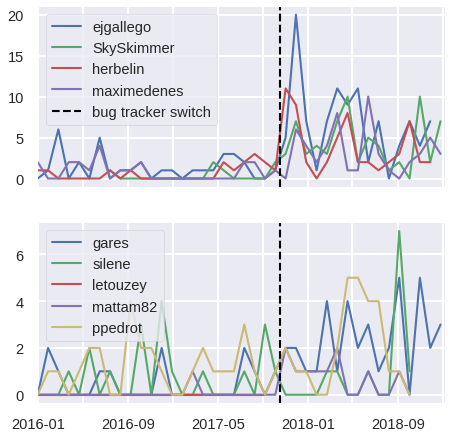

In [41]:
def local():

  def reporter_graph(author):
    _,_,_,_,issues_4W = df_1D_1W_2W_4W(issues[
        (issues['author'] == author)
    ])
    plt.plot(issues_4W['count'],'-',label=author)

  ax1 = plt.subplot(2,1,1)
  for reporter in ['ejgallego','SkySkimmer','herbelin','maximedenes']:
    reporter_graph(reporter)
  plt.axvline(x=switch_date,linestyle='--',color='black',label='bug tracker switch')
  plt.setp(ax1.get_xticklabels(), visible=False)
  plt.legend(loc='upper left')

  ax2 = plt.subplot(2,1,2,sharex=ax1)
  for reporter in ['gares','silene','letouzey','mattam82','ppedrot']:
    reporter_graph(reporter)
  plt.axvline(x=switch_date,linestyle='--',color='black',label='')
  plt.legend(loc='upper left')

  plt.xlim(left=pd.datetime(2016,1,1),right=data_collection_date)
  
  less_ticks(ax2,2)
  
  #plt.savefig('bugs_individual_devs.png')

local()

### Biggest reporters (period of 40 weeks before to 40 weeks after the switch)

In [42]:
def local():

  issues_grouped_by_author = issues[
      (issues['reldate_4W'] >= -10) &
      (issues['reldate_4W'] < 10)
  ].groupby('author').sum().sort_values(
      'count',
      ascending=False
  )

  return issues_grouped_by_author.assign(
      bugs_before=issues_grouped_by_author['count']-issues_grouped_by_author['after_switch'].astype(int),
      bugs_after=issues_grouped_by_author['after_switch'].astype(int)
  )[['bugs_before','bugs_after']].head(10)

local()

bugs_before  bugs_after
author                                
ejgallego               12          80
RalfJung                20          48
herbelin                11          42
SkySkimmer               5          48
tchajed                 34          11
maximedenes              5          39
ppedrot                 11          24
andres-erbsen            0          28
gares                    4          21
anton-trunov             0          24

### Biggest commentators (period of 40 weeks before to 40 weeks after the switch)

In [43]:
def local():

  comments_grouped_by_author = comments[
      (comments['reldate_4W'] >= -10) &
      (comments['reldate_4W'] < 10)
  ].groupby('author').sum().sort_values(
      'count',
      ascending=False
  )

  return comments_grouped_by_author.assign(
      bugs_before=comments_grouped_by_author['count']-comments_grouped_by_author['after_switch'].astype(int),
      bugs_after=comments_grouped_by_author['after_switch'].astype(int)
  )[['bugs_before','bugs_after']].head(10)

local()

bugs_before  bugs_after
author                              
ejgallego            280         754
herbelin             153         321
maximedenes           88         364
ppedrot               84         266
SkySkimmer            18         305
gares                 44         198
psteckler            116          91
RalfJung              76         125
mattam82              33         119
silene               100           8

## Main results

In this section, we do (linear) Regressions in Discontinuity analyses on a time window of 180 periods before and after the switch, for our four main outcomes. For number of reports and number of comments, we use 1-day periods. For number of distrinct reporters and number of distinct commenters, we use one week periods. In addition we also include in this notebook the results for the number of new bug reporters and commentators (with one day periods).

Note that, to help readbility of the graphs, the individual points represented are two-week means of the data used for the regression. The regression lines presented still use the full dataset.

In [0]:
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import summary_table
from IPython.display import display,HTML
import numpy as np

def select_periods(df,period_nb):
  return df[
      (df['reldate'] >= -period_nb) &
      (df['reldate'] < period_nb)
  ]

def rd(data,variable,degree,robust,control_release=False):
  robustargs = {'cov_type': 'HC1'} if robust else {}
  formula = variable
  formula += ' ~ after_switch'
  if degree >= 1:
    formula += ' + reldate + after_switch*reldate'
  if degree >= 2:
    formula += ' + reldate_square + after_switch*reldate_square'
  if degree >= 3:
    formula += ' + reldate_cube + after_switch*reldate_cube'
  
  if control_release:
    release_nb = 2
    formula += f' + after_release + after_beta'
  else :
    release_nb = 0
  
  results = smf.ols(
      formula=formula,
      data=data.assign(
          reldate_square=data['reldate']*data['reldate'],
          reldate_cube=data['reldate']*data['reldate']*data['reldate']
      )
  ).fit(**robustargs)
    
  def stars(p):
    if p < 0.001:
      return '***'
    elif p < 0.01:
      return '** '
    elif p < 0.05:
      return '*  '
    elif p < 0.1:
      return '†'
    else:
      return '   '
  
  values = list(zip(*[
      results.params,
      map(stars,results.pvalues),
      results.bse,
      results.pvalues
  ]))
  
  #print(results.model.exog_names)
  
  table = '<pre>'
  table += f'Outcome variable:\t{variable}\n'
  table += f'No of observations:\t{results.nobs}\n'
  table += '                      \tcoef\t\tstd err\t\tP>|t|\n'
  table += '-----------------------------------------------------------------\n'
  table += 'after switch          \t %.3g %s  \t(%.3g)   \t%.3g\n' % tuple(values[1])
  if degree >= 1:
    table += 'after switch*reldate\t %.3g %s  \t(%.3g)   \t%.3g\n' % tuple(values[3+release_nb])
    table += 'reldate               \t %.3g %s  \t(%.3g)   \t%.3g\n' % tuple(values[2+release_nb])
  if degree >= 2:
    table += 'after switch*reldate_sq %.3g %s  \t(%.3g)   \t%.3g\n' % tuple(values[5+release_nb])
    table += 'reldate_sq        \t %.3g %s  \t(%.3g)   \t%.3g\n' % tuple(values[4+release_nb])
  if degree >= 3:
    table += 'after switch*reldate_cb %.3g %s  \t(%.3g)   \t%.3g\n' % tuple(values[7+release_nb])
    table += 'reldate_cb        \t %.3g %s  \t(%.3g)   \t%.3g\n' % tuple(values[6+release_nb])
  table += 'constant              \t %.3g %s  \t(%.3g)   \t%.3g' % tuple(values[0])
  if control_release:
    table += f'\nafter_release    \t %.3g %s  \t(%.3g)   \t%.3g' % tuple(values[2])
    table += f'\nafter_beta       \t %.3g %s  \t(%.3g)   \t%.3g' % tuple(values[3])
  table += '</pre><br><br>'
  
  display(HTML(table))
  
  return results

def plot_rd_line(index,results,periods,color,label=''):
  plt.plot(index[:periods],results.predict()[:periods],color=color)
  plt.plot(index[periods:],results.predict()[periods:],color=color,label=label)

def plot_conf_int(index,results,periods,color,label=''):
  _, data, _ = summary_table(results, alpha=0.05)
  
  # Get the confidence intervals of the model
  low_CI, upper_CI = data[:,4:6].T
  
  # Shade the confidence interval
  plt.fill_between(index[:periods],low_CI[:periods],upper_CI[:periods],color=color,alpha=0.2,label=label)
  plt.fill_between(index[periods:],low_CI[periods:],upper_CI[periods:],color=color,alpha=0.2,label=label)

In [0]:
def hetero_analysis(rd_data,variable,label_all,label_dev,label_others,periods=455,degree=1,plot_data=None,filename=None,control_release=False):

  rd_data = select_periods(rd_data,periods)
  
  if plot_data is None:
    plot_data = rd_data

  dev_variable = f'dev_{variable}'
  other_variable = f'other_{variable}'
  

  degree_all = degree
  degree_devs = degree
  degree_others = degree
  
  everyone = rd(rd_data,variable,degree=degree_all,robust=True,control_release=control_release)
  devs = rd(rd_data,dev_variable,degree=degree_devs,robust=True,control_release=control_release)
  others = rd(rd_data,other_variable,degree=degree_others,robust=True,control_release=control_release)
  
  _, ax = plt.subplots()
  
  plot_rd_line(rd_data.index,devs,periods,'indigo')
  plot_conf_int(rd_data.index,devs,periods,'indigo')
  plt.plot(plot_data[dev_variable],'.',color='indigo',label=label_dev)
  
  plot_rd_line(rd_data.index,others,periods,'#ff8c00')
  plot_conf_int(rd_data.index,others,periods,'#ff8c00')
  plt.plot(plot_data[other_variable],'.',color='#ff8c00',label=label_others)
  
  plt.axvline(x=switch_date,color='black', linestyle='--')
  plt.legend()

  less_ticks(ax,2)
  
  # Now let's write some LaTeX files with these tables
  
  def get_param(results, i):
    try:
      return '%.3g' % results.params[i]
    except IndexError:
      return ''
  
  def get_pvalue(results, i):
    try:
      p = results.pvalues[i]
    except IndexError:
      return ''
    if p < 0.001:
      return '***'
    elif p < 0.01:
      return '**'
    elif p < 0.05:
      return '*'
    elif p < 0.1:
      return '$\dagger$'
    else:
      return ''
  
  def get_bse(results,i):
    try:
      return '(%.3g)' % results.bse[i]
    except IndexError:
      return ''
  
  def row(name1,name2,i):
    return '%s & %s%s & %s%s & %s%s \\\\\n' % (
        name1,
        get_param(everyone,i),
        get_pvalue(everyone,i),
        get_param(devs,i),
        get_pvalue(devs,i),
        get_param(others,i),
        get_pvalue(others,i)
    ) + '%s & %s & %s & %s \\\\\n' % (
        name2,
        get_bse(everyone,i),
        get_bse(devs,i),
        get_bse(others,i)
    ) + '\\hline\n'
  
  latex = """\\begin{tabular}{|r|c|c|c|}
\\hline
&  Total & Developers & Others \\\\
\\hline
"""
  latex += row('$\\mbox{\\emph{After switch}}_p$','',1)
  latex += row('$\\mbox{\\emph{Relative date}}_p$','$\\times \\mbox{\\emph{After switch}}_p$',3)
  latex += row('$\\mbox{\\emph{Relative date}}_p$','',2)
  if degree == 2:
    latex += row('$\\mbox{\\emph{Relative date}}_p^2$','$ \\times \\mbox{\\emph{After switch}}_p$',5)
    latex += row('$\\mbox{\\emph{Relative date}}_p^2$','',4)
  latex += row('Constant','',0)
  latex += 'Observation number & %d & %d & %d \\\\\n' % (
      everyone.nobs,
      devs.nobs,
      others.nobs
  )
  latex += '\\hline\n\\end{tabular}'
  
  if not filename is None:
    plt.savefig(f'{filename}.png')
    with open(f'{filename}.tex', 'w') as f:
      f.write(latex)

def homo_analysis(rd_data,variable,label='',periods=455,degree=1,plot_data=None,control_release=False):

  rd_data = select_periods(rd_data,periods)
  
  if plot_data is None:
    plot_data = rd_data

  results = rd(rd_data,variable,degree=degree,robust=True,control_release=control_release)
  
  _, ax = plt.subplots()
  
  plot_rd_line(rd_data.index,results,periods,'black')
  plot_conf_int(rd_data.index,results,periods,'black')
  plt.plot(plot_data[variable],'.',color='black',label=label)

  plt.axvline(x=switch_date,color='black', linestyle='--')
  if label != '':
    plt.legend()

  less_ticks(ax,2)

# Aggregate weekly data into biweekly data
def half_rate(data_1W):
  data_2W = data_1W.copy()
  data_2W["date"] = pd.to_timedelta(data_2W.index.to_series()).dt.total_seconds()
  r =data_2W.assign(reldateround2=data_2W["reldate"]-data_2W["reldate"]%2+1).groupby('reldateround2').mean()
  r["date"] = pd.to_datetime(pd.to_timedelta(r["date"], unit='s'))
  return r.set_index("date")

### Number of reports

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


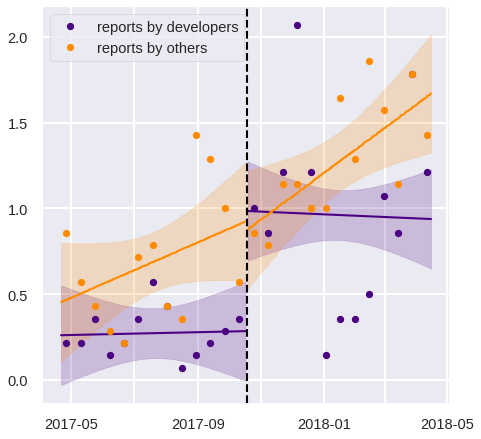

In [46]:
hetero_analysis(
    issues_1D,
    'count',
    'reports by everyone',
    'reports by developers',
    'reports by others',
    periods=180,
    plot_data=select_periods(issues_2W,13)/14,
    filename='bug_nb_rd'
)

### Number of  reporters

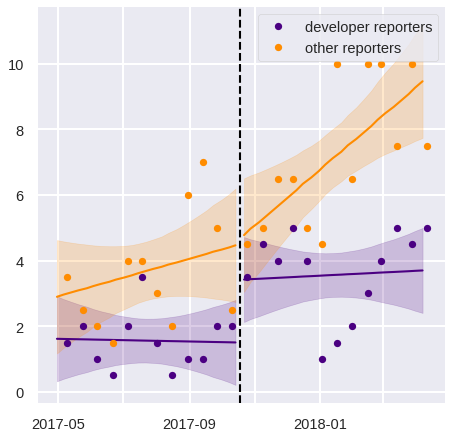

In [47]:


hetero_analysis(
    issues_1W,
    'author',
    'all reporters',
    'developer reporters',
    'other reporters',
    periods=25,
    filename='reporter_nb_rd',
    plot_data=select_periods(half_rate(issues_1W), 25)
)

### Number of new reporters

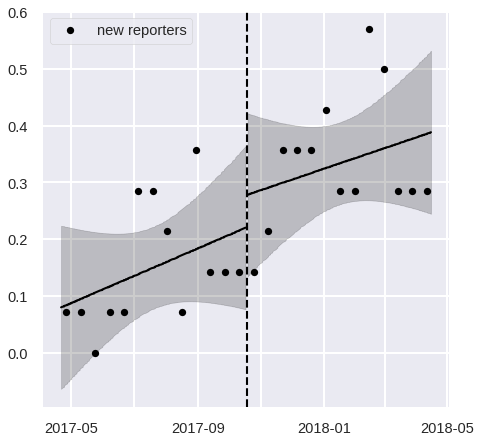

In [48]:
homo_analysis(issues_1D,'new','new reporters',periods=180,plot_data=select_periods(issues_2W,13)/14)

### Number of comments

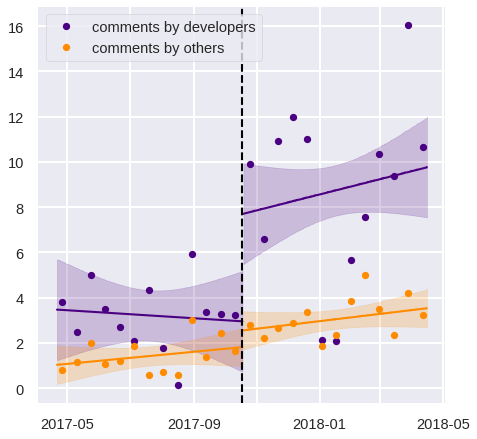

In [49]:
hetero_analysis(
    comments_1D,
    'count',
    'all comments',
    'comments by developers',
    'comments by others',
    periods=180,
    plot_data=select_periods(comments_2W,13)/14,
    filename='comment_nb_rd'
)

### Number of commentators

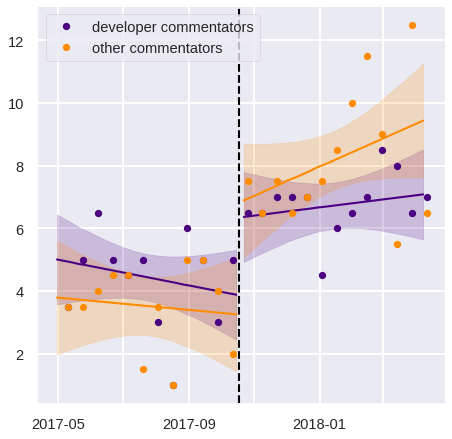

In [50]:
hetero_analysis(
    comments_1W,
    'author',
    'all commentators',
    'developer commentators',
    'other commentators',
    periods=25,
    filename='commentator_nb_rd',
    plot_data=select_periods(half_rate(comments_1W), 25)
)

### Number of new commentators

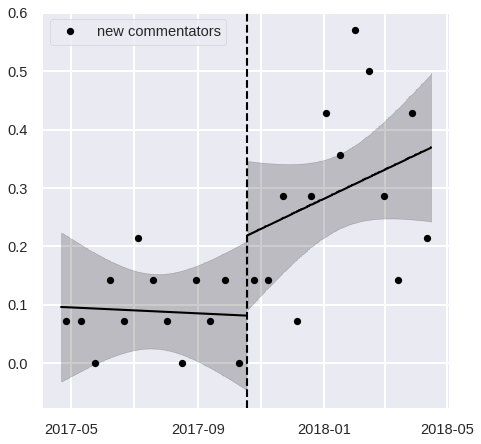

In [51]:
homo_analysis(comments_1D,'new',label='new commentators',periods=180,plot_data=select_periods(comments_2W,13)/14)

## Robustness checks


### Internal validity

For every outcome variable, we also test degree zero polynomials (ie constants) on 180 and 455 days, and linear and quadratic specifications on 455 days.  For all specifications, we also try removing the 2 weeks after the switch from the data, and adding a binary control for being two weeks after a release and two weeks after a beta release. This last robustness check is to try to remove the potential effect of the 8.7.0 release (which was concomittant with the migration), and the migration short-term impact.



In [0]:
import scipy.stats


# Tests for 1-day periods (or 1-week periods if weekly_data=True)
# Three flavors: full / exclude / control
# In this:
#  - Partial data (180 days before and after the switch): constant / linear
#  - Full data (455 days before and after the switch): constant / linear / quadratic

def robustness_checks(data_main,data_2W,variable,analysis_type='heterogeneous',weekly_data=False,version='full'):
  control_release = False
  if version == 'exclude':
    limit = 2 if weekly_data else 14
    data_main = data_main[(data_main['reldate'] < 0) | (data_main['reldate'] >= limit)]
    data_2W = data_2W[(data_2W['reldate'] < 0) | (data_2W['reldate'] >= 1)]
  if version == 'control':
    control_release=True
  for periods_1D, periods_1W, periods_2W in [(180,25,12), (455,65,33)]:
    periods = periods_1W if weekly_data else periods_1D
    plot_data = select_periods(data_2W, periods_1W) if weekly_data else select_periods(data_2W,periods_2W)/14
    print(f'** {periods} {"1-week" if weekly_data else "1-day"} periods ({periods_1W} weeks before and after switch) **')
    for degree in [0,1,2]:
      if degree < 2 or periods_1D == 455:
        if analysis_type == 'heterogeneous':
          hetero_analysis(data_main,variable,'all','dev','other',periods=periods,degree=degree,plot_data=plot_data,control_release=control_release)
        else:
          homo_analysis(data_main,variable,variable,periods=periods,degree=degree,plot_data=plot_data,control_release=control_release)


#### Number of reports

** 180 1-day periods (25 weeks before and after switch) **


** 455 1-day periods (65 weeks before and after switch) **


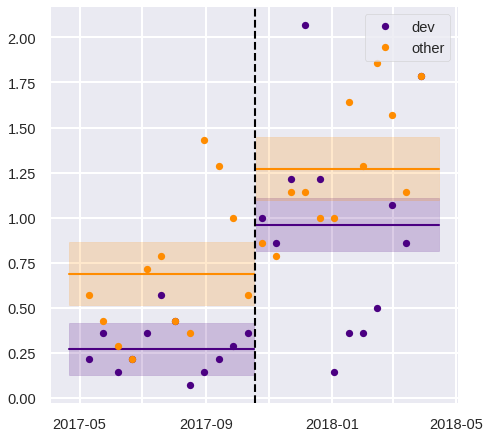

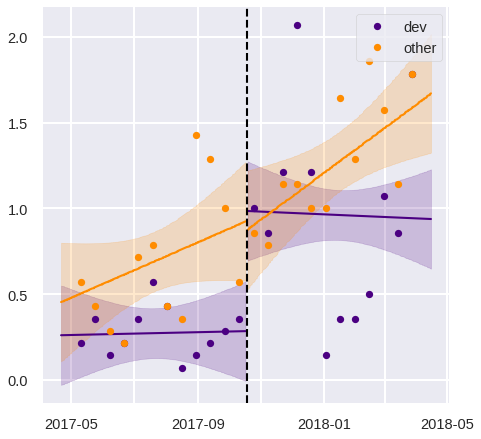

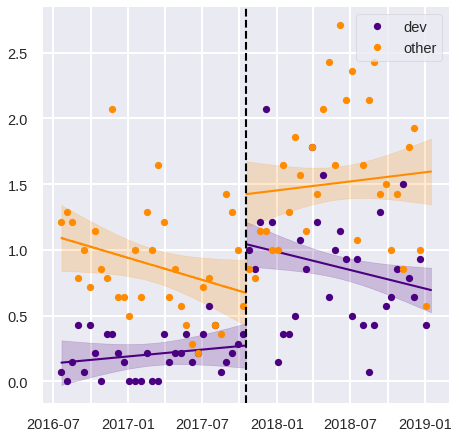

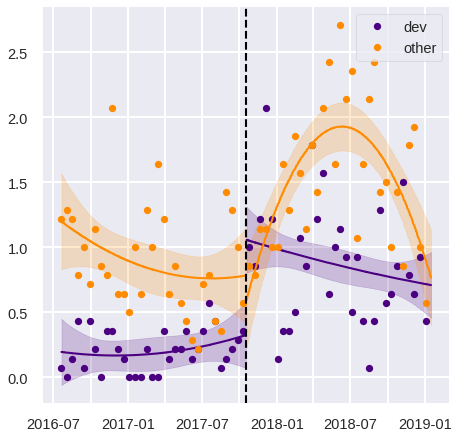

In [53]:
robustness_checks(issues_1D,issues_2W,'count')

** 180 1-day periods (25 weeks before and after switch) **


** 455 1-day periods (65 weeks before and after switch) **


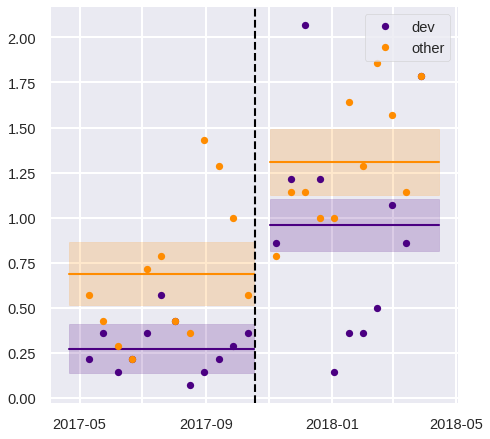

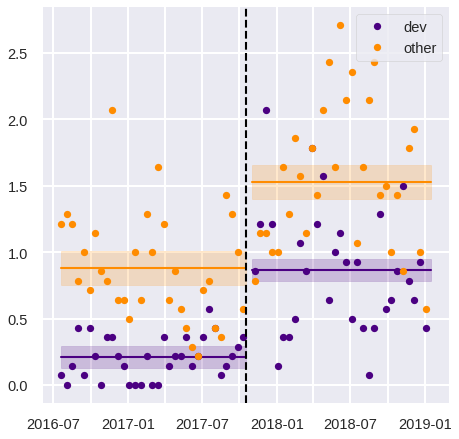

In [54]:
robustness_checks(issues_1D,issues_2W,'count',version='exclude')

** 180 1-day periods (25 weeks before and after switch) **


** 455 1-day periods (65 weeks before and after switch) **


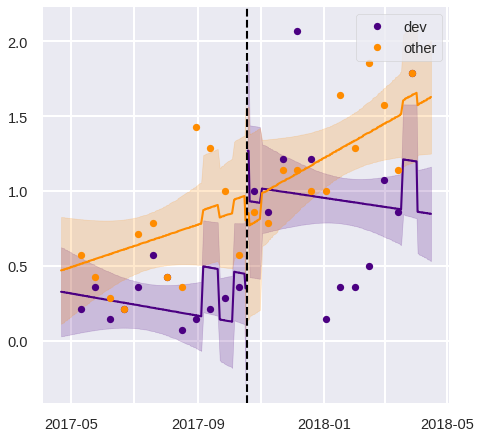

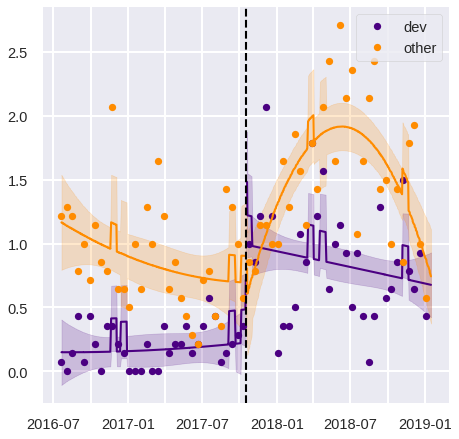

In [55]:
robustness_checks(issues_1D,issues_2W,'count',version='control')

#### Number of reporters

** 25 1-week periods (25 weeks before and after switch) **


** 65 1-week periods (65 weeks before and after switch) **


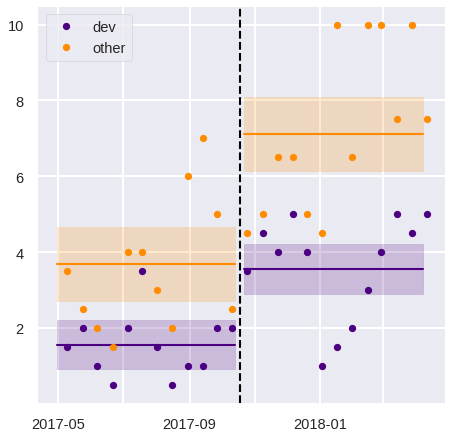

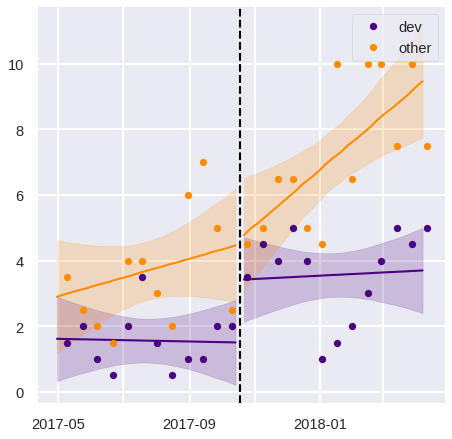

In [56]:
robustness_checks(issues_1W,half_rate(issues_1W),'author',weekly_data=True)

** 25 1-week periods (25 weeks before and after switch) **


** 65 1-week periods (65 weeks before and after switch) **


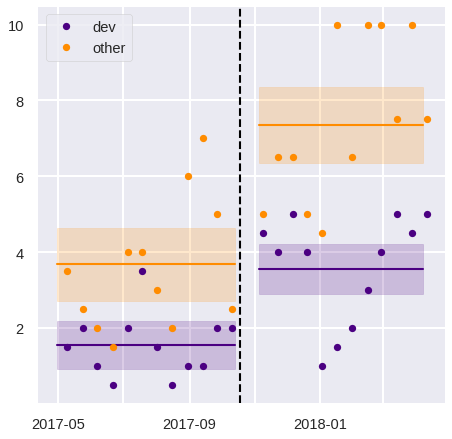

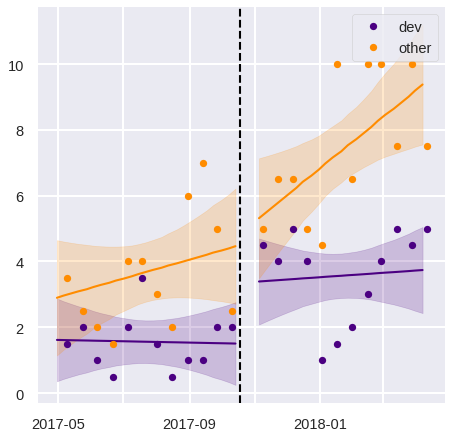

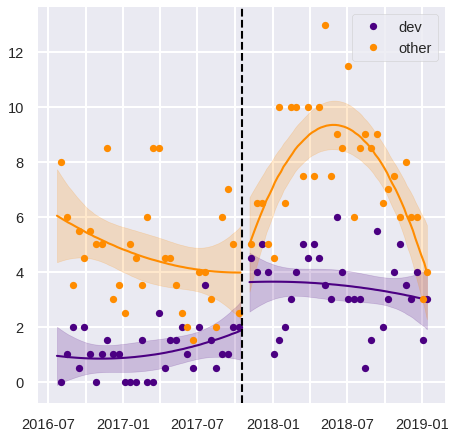

In [57]:
robustness_checks(issues_1W,half_rate(issues_1W),'author',weekly_data=True, version='exclude')

** 25 1-week periods (25 weeks before and after switch) **


** 65 1-week periods (65 weeks before and after switch) **


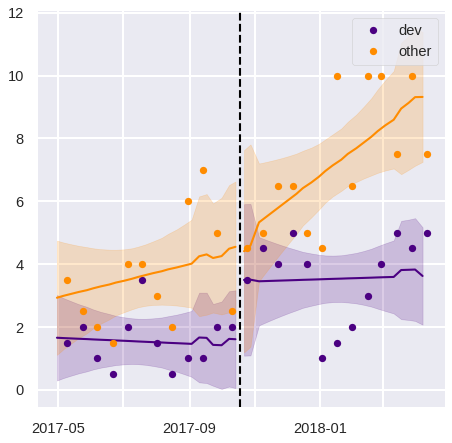

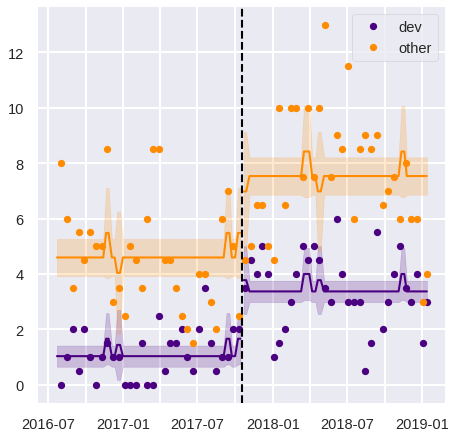

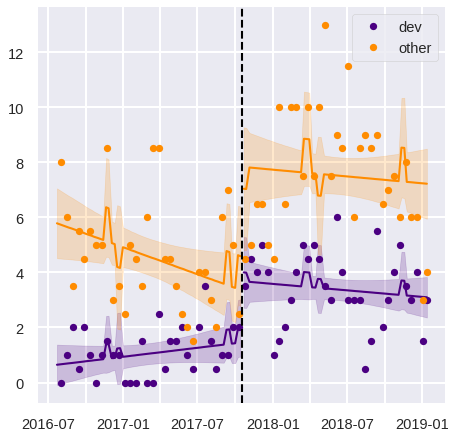

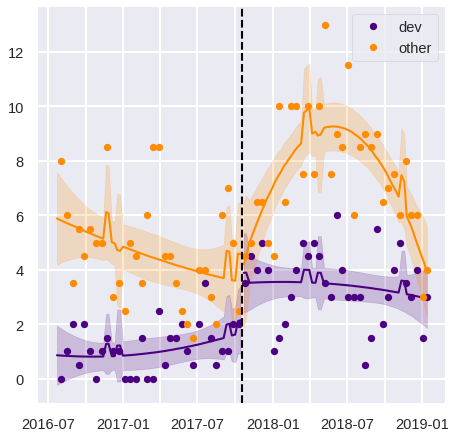

In [58]:
robustness_checks(issues_1W,half_rate(issues_1W),'author',weekly_data=True, version='control')

#### Number of new reporters

** 180 1-day periods (25 weeks before and after switch) **


** 455 1-day periods (65 weeks before and after switch) **


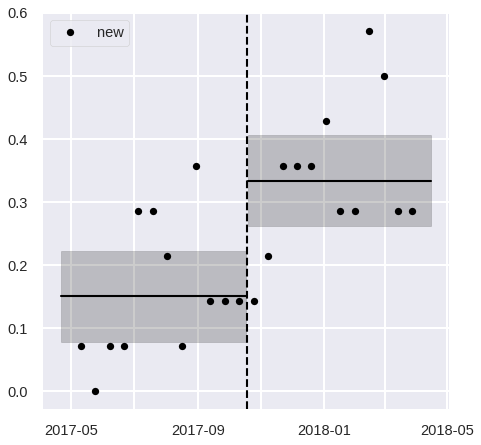

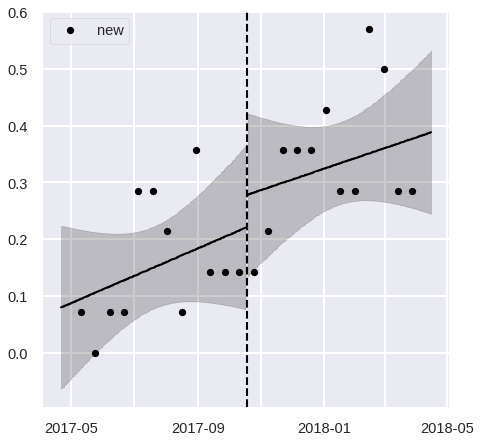

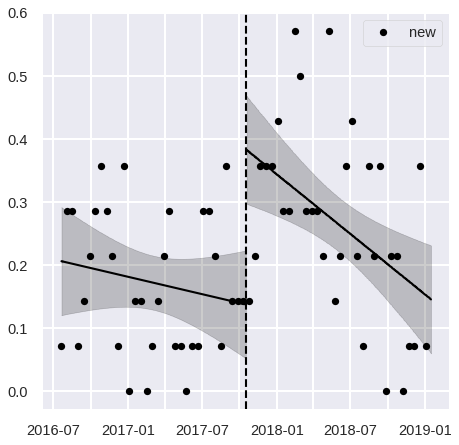

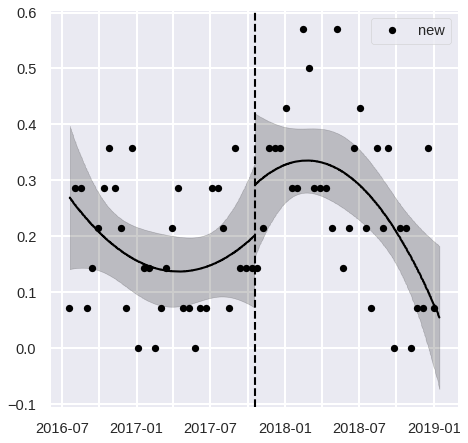

In [59]:
robustness_checks(issues_1D,issues_2W,'new',analysis_type='homogeneous')

#### Number of comments

** 180 1-day periods (25 weeks before and after switch) **


** 455 1-day periods (65 weeks before and after switch) **


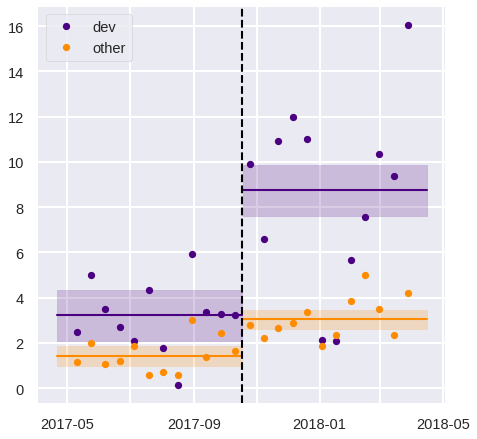

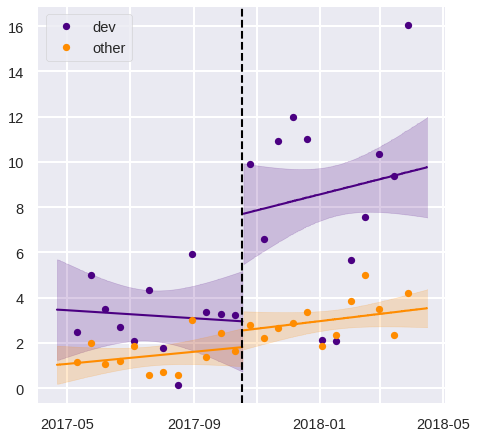

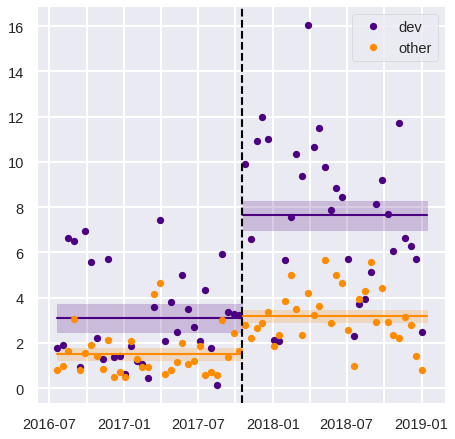

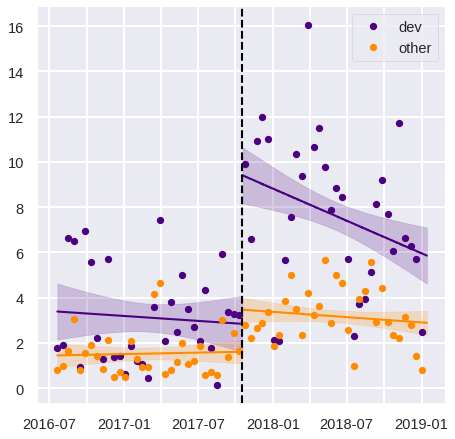

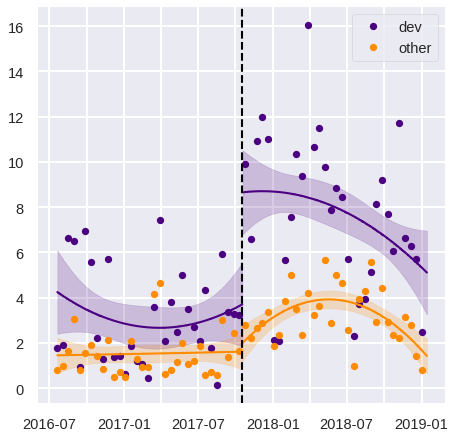

In [60]:
robustness_checks(comments_1D,comments_2W,'count')

** 180 1-day periods (25 weeks before and after switch) **


** 455 1-day periods (65 weeks before and after switch) **


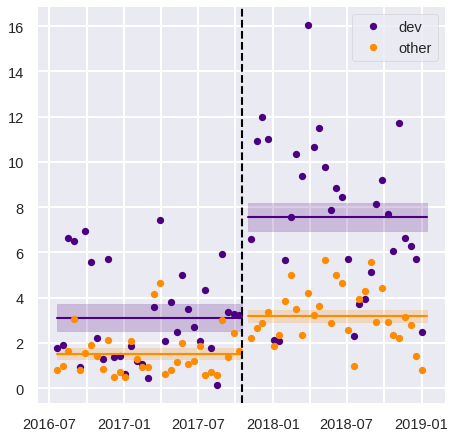

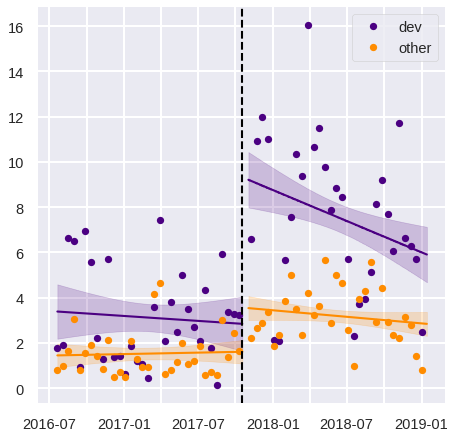

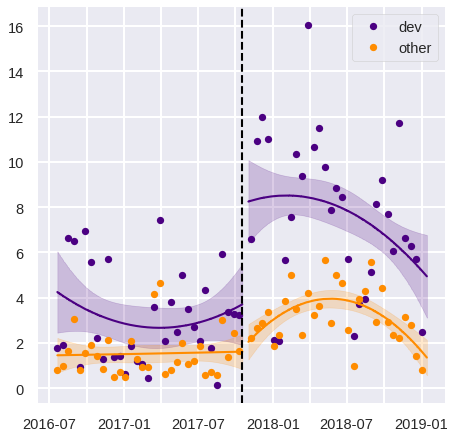

In [61]:
robustness_checks(comments_1D,comments_2W,'count',version='exclude')

** 180 1-day periods (25 weeks before and after switch) **


** 455 1-day periods (65 weeks before and after switch) **


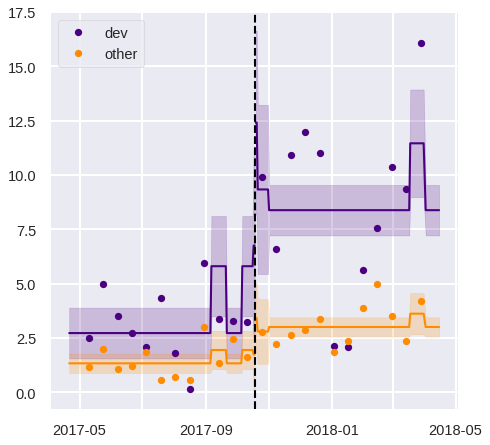

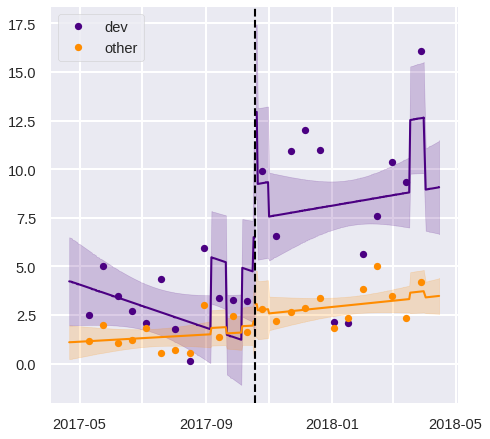

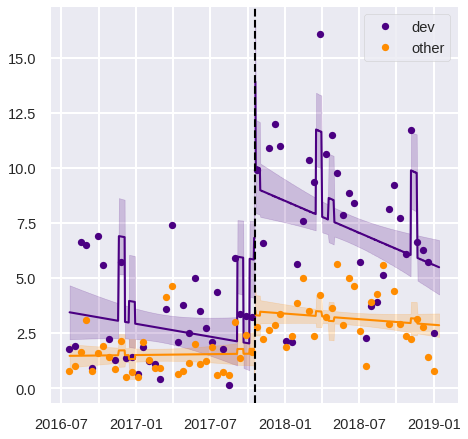

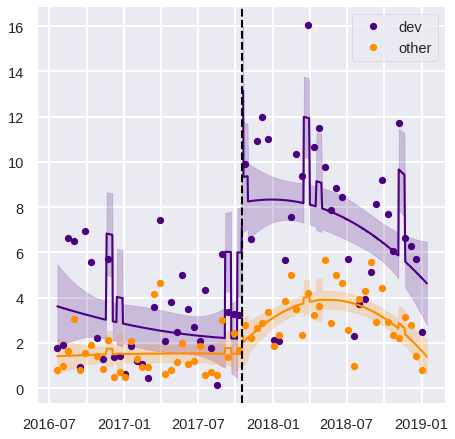

In [62]:
robustness_checks(comments_1D,comments_2W,'count',version='control')

#### Number of commentators

** 25 1-week periods (25 weeks before and after switch) **


** 65 1-week periods (65 weeks before and after switch) **


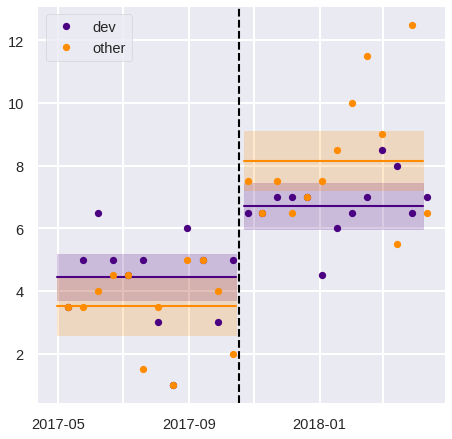

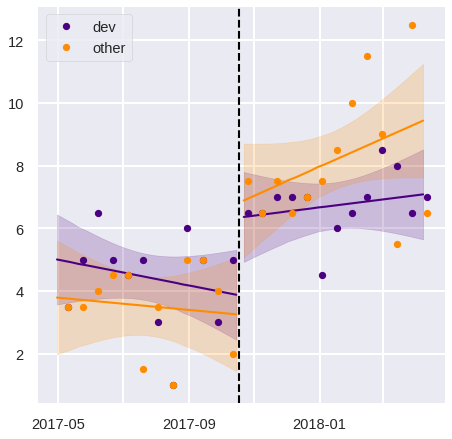

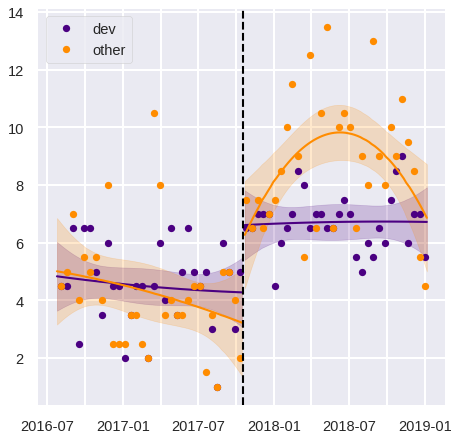

In [63]:
robustness_checks(comments_1W,half_rate(comments_1W),'author',weekly_data=True)

** 25 1-week periods (25 weeks before and after switch) **


** 65 1-week periods (65 weeks before and after switch) **


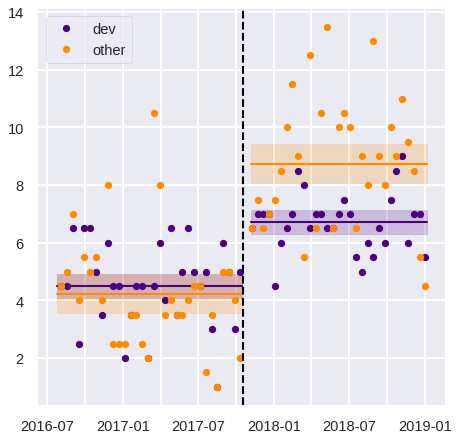

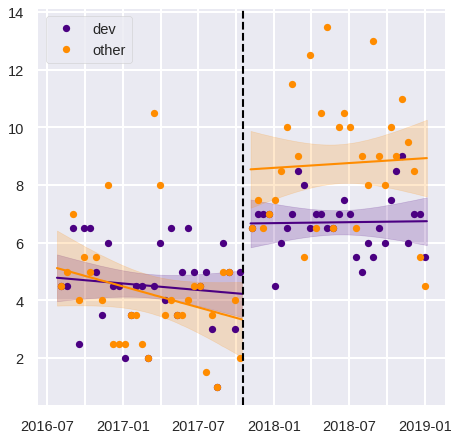

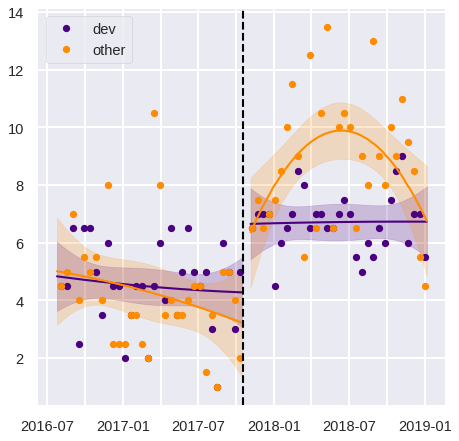

In [64]:
robustness_checks(comments_1W,half_rate(comments_1W),'author',weekly_data=True,version='exclude')

** 25 1-week periods (25 weeks before and after switch) **


** 65 1-week periods (65 weeks before and after switch) **


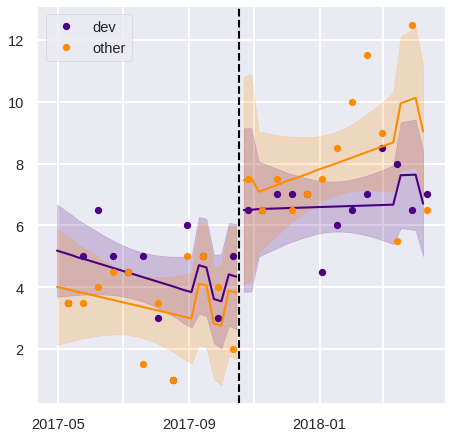

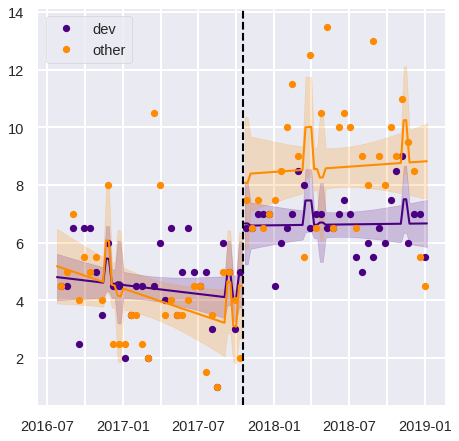

In [65]:
robustness_checks(comments_1W,half_rate(comments_1W),'author',weekly_data=True,version='control')

#### Number of new commentators

** 180 1-day periods (25 weeks before and after switch) **


** 455 1-day periods (65 weeks before and after switch) **


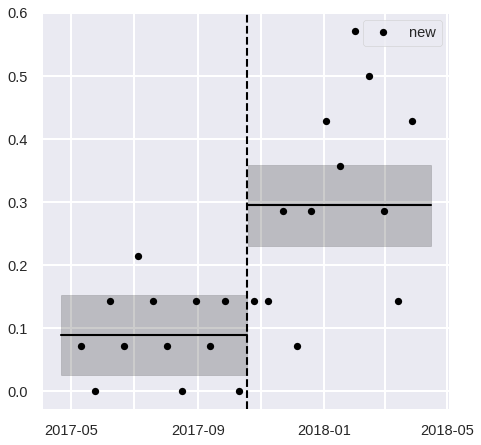

In [66]:
robustness_checks(comments_1D,comments_2W,'new',analysis_type='homogeneous')

** 180 1-day periods (25 weeks before and after switch) **


** 455 1-day periods (65 weeks before and after switch) **


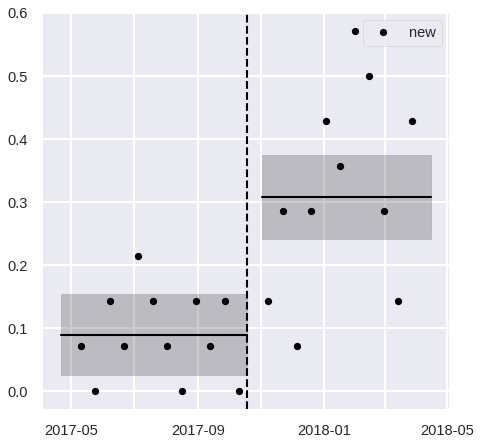

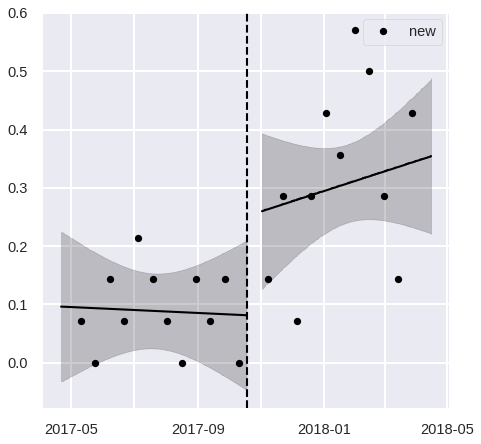

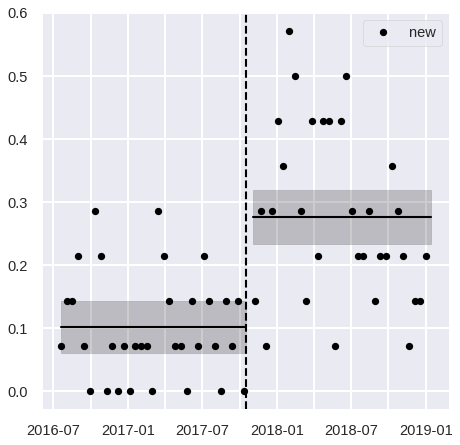

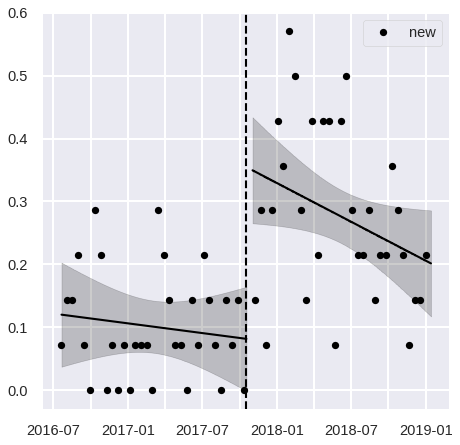

In [67]:
robustness_checks(comments_1D,comments_2W,'new',analysis_type='homogeneous',version='exclude')

** 180 1-day periods (25 weeks before and after switch) **


** 455 1-day periods (65 weeks before and after switch) **


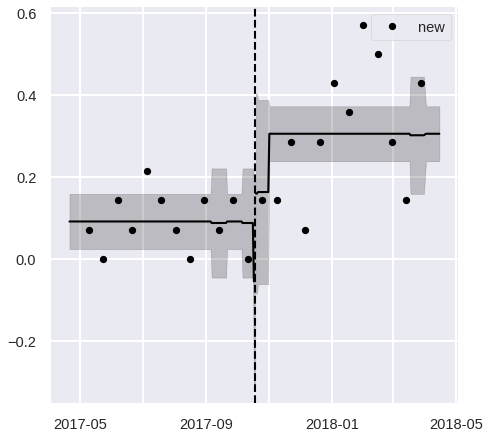

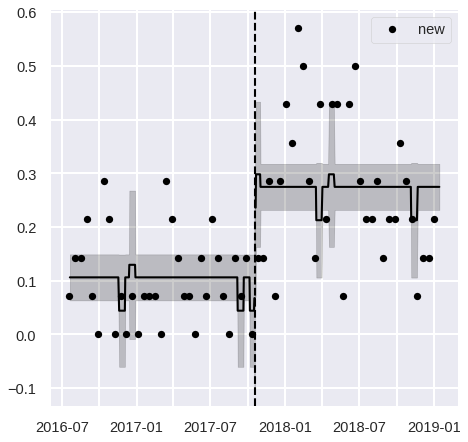

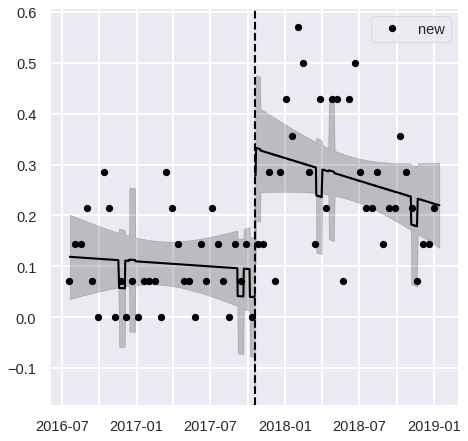

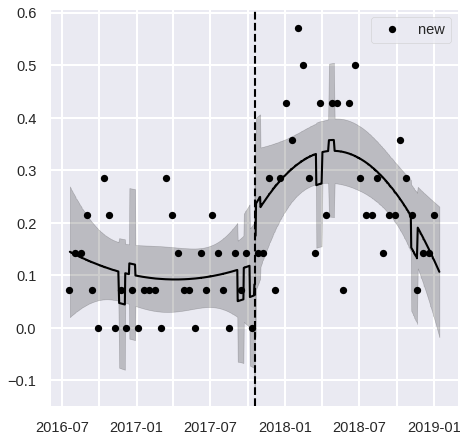

In [68]:
robustness_checks(comments_1D,comments_2W,'new',analysis_type='homogeneous',version='control')

### External validity

In this section, we look at another project that did a similar switch: Ledger.

As for Coq, we start by fetching the data.

In [69]:
fetch_issues('ledger',prefix='ledger_')
fetch_prs('ledger',prefix='ledger_')
fetch_issue_comments('ledger',prefix='ledger_')
fetch_pr_comments('ledger',prefix='ledger_')

ledger_issues = load_csv('ledger_issues.csv')
ledger_prs = load_csv('ledger_pullrequests.csv')
ledger_comments = load_csv('ledger_comments.csv')
ledger_pr_comments = load_csv('ledger_pr_comments.csv')

File retrieved from local file system: ledger_issues.csv
File retrieved from local file system: ledger_pullrequests.csv
File retrieved from local file system: ledger_comments.csv
File retrieved from local file system: ledger_pr_comments.csv


We remove artefact migration comments.

In [0]:
ledger_comments = remove_migration_artifact_comments(ledger_issues,ledger_comments)

We group by periods. All the author information will be unusable because the Ledger migration did not preserve author information for users that could not be matched to a GitHub username.

In [0]:
ledger_switch_date = pd.datetime(2018,1,23)

ledger_issues,_,_,_,ledger_issues_4W = df_1D_1W_2W_4W(ledger_issues,switch_date=ledger_switch_date)
ledger_prs,_,_,_,ledger_prs_4W = df_1D_1W_2W_4W(ledger_prs,switch_date=ledger_switch_date)
ledger_comments,_,_,_,ledger_comments_4W = df_1D_1W_2W_4W(ledger_comments,switch_date=ledger_switch_date)
ledger_pr_comments,_,_,_,ledger_pr_comments_4W = df_1D_1W_2W_4W(ledger_pr_comments,switch_date=ledger_switch_date)

Bug data from before 2013-7-23 is difficult to interpret because at that time both GitHub issue tracker and the Bugzilla instance were opened, even if only the latter was the official bug tracker.

In [0]:
github_issue_close_date = pd.datetime(2013,7,23)

#### Number of bugs and pull requests

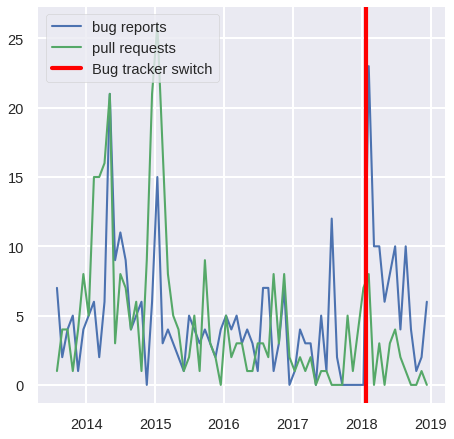

In [73]:
def local():

  plt.plot(ledger_issues_4W[ledger_issues_4W.index>github_issue_close_date]['count'],label='bug reports')
  plt.plot(ledger_prs_4W[ledger_prs_4W.index>github_issue_close_date]['count'],label='pull requests')
  plt.axvline(x=ledger_switch_date,color='red',lw=2,label='Bug tracker switch')
  plt.legend()

local()

#### Number of bug and pull request comments

In [74]:
def local():

  plt.plot(ledger_comments_4W[ledger_comments_4W.index>github_issue_close_date]['count'],label='bug comments')
  plt.plot(ledger_pr_comments_4W[ledger_pr_comments_4W.index>github_issue_close_date]['count'],label='pull request comments')
  plt.axvline(x=ledger_switch_date,color='red',lw=2,label='Bug tracker switch')
  plt.legend()

local()